# Neighborhood Cleanliness and Yelp Review Ratings in Philadelphia

**Team Members:** Jessica Yang, Julie Dai, Yukun Zhou

[Presentation Video Link](https://drive.google.com/file/d/1YE1QRNoLL8Hw51g77rJvwg4yMGI1fPfn/view?usp=sharing)

## Introduction

Our project examines how neighborhood conditions relate to the experiences people share on Yelp. Online reviews offer a huge amount of information about customer satisfaction, but they rarely reflect what is happening in the surrounding area. By combining Yelp data with detailed records of 311 cleanliness complaints, we can study how the environment outside a restaurant might influence the ratings it receives. The goal is to connect individual reviews to broader neighborhood patterns in a structured and measurable way.

## Motivation

Philadelphia has large differences in cleanliness and infrastructure across its neighborhoods, and these differences may shape how customers perceive local businesses. Yelp reviews often focus on food and service, yet a poor environment can affect expectations before a customer even walks in the door. We were motivated by the idea that ratings might capture more than what happens inside a restaurant. Exploring this connection can help cities and businesses understand how local conditions influence public perception.

## Research Question

**Do restaurants in areas with more cleanliness complaints tend to receive lower ratings after controlling for typical Yelp features?**

We aim to understand whether neighborhood cleanliness is associated with the star ratings that restaurants receive on Yelp. We study this at the review level so that each individual rating can be linked to the real conditions of the surrounding neighborhood. This allows us to capture variation across both time and space.

## Plan

We combine data from Yelp reviews and businesses with 311 service request data that measures neighborhood cleanliness. After cleaning and linking these datasets, we create review level features that reflect both restaurant attributes and local environmental conditions. We begin with a baseline model using Yelp only information, then add neighborhood variables to assess their predictive value. This structure allows us to isolate the contribution of cleanliness while keeping the analysis grounded in real review behavior.

## Section 0: Imports

In this section, we load all of the core libraries and tools that will support the remainder of our analysis.  

In [1]:
# Imports

# Core Data Libraries
import os
import json
from pathlib import Path
from datetime import timedelta
from typing import List, Dict, Iterable, Tuple

import pandas as pd
import numpy as np

# Geospatial Libraries
import geopandas as gpd
from shapely.geometry import Point

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn: Preprocessing, Modeling, Evaluation
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Gradient Boosting Models
from xgboost import XGBRegressor


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Section 1: Data Overview and Data Loading

This section provides an overview of all datasets used in the project and loads the Yelp business, Yelp review, and 311 complaint data into clean, filtered DataFrames that will serve as the foundation for all later spatial analysis, feature engineering, and modeling.

### Section 1.1: Dataset Descriptions

In this project, we will work with multiple real-world datasets that we integrate into a single review level modeling table. Below, we briefly describe each dataset and how it fits into our analysis.

#### 1. Yelp Business Data (`business.json`)

The Yelp business dataset contains business level metadata for a wide variety of entities on Yelp. For this project, we focus on restaurants located in Philadelphia.

Key fields we will use include:
- `business_id`: unique identifier for each business (used to join with review data).  
- `name`: restaurant name.  
- `categories`: comma-separated list of business categories used to identify restaurants and approximate cuisine types.  
- `city`, `state`: used to filter to Philadelphia restaurants.  
- `latitude`, `longitude`: geographic coordinates used for spatial joins with neighborhood polygons.  
- `stars`: average star rating of the business across all reviews on Yelp.  
- `review_count`: total number of reviews for the business.  
- `price`: approximate price tier (`$`, `$$`, `$$$`), used as a proxy for cost level.

We will filter this dataset to restaurants in Philadelphia and use it to define our restaurant universe and restaurant level features.

#### 2. Yelp Review Data (`review.json`)

The Yelp review dataset contains one row per individual review left by a user for a business.

Key fields we will use include:
- `review_id`: unique identifier for the review.  
- `business_id`: foreign key linking each review to a business in `business.json`.  
- `user_id`: identifier of the user leaving the review.  
- `stars`: the star rating given in this specific review which is our primary target variable at the review level.  
- `date`: timestamp of when the review was written.  
- `text`: the full free-text content of the review which is not central to our main models, but available for potential extensions.

After filtering to reviews associated with Philadelphia restaurants, this dataset will form the core of our review level table, which we will later enrich with restaurant attributes and neighborhood cleanliness features.

#### 3. Philadelphia 311 Service Requests (Sanitation Complaints)

The Philadelphia 311 dataset consists of service requests submitted by residents for issues such as trash, illegal dumping, missed pickups, and recycling concerns. Because these data are collected over multiple years and exported from OpenDataPhilly, some fields vary slightly across CSV files. However, the main fields used in our analysis are consistent:

Key fields we will use include:
- `service_name` or `request_type`: identifies the category of complaint ("Illegal Dumping", "Rubbish/Recycling Collection", "Missed Pickup").
- `requested_datetime`: timestamp of when the service request was created.
- `latitude`, `longitude`: location of the complaint, used for spatial assignment to neighborhoods.
- `status`: optional field indicating whether the request is open or closed which is not directly used in modeling but present in the dataset.

From these records, we compute neighborhood-level cleanliness indicators using total sanitation complaints, illegal dumping counts and proportions, complaint densities (complaints per square mile), and recent activity windows (complaints in past 30 / 90 days).

#### 4. Philadelphia Neighborhood Boundaries (Shapefile/GeoJSON)

The neighborhood boundaries dataset provides polygon geometries delineating the borders of neighborhoods within Philadelphia.

Key fields we will use include:
- `geometry`: polygon defining the neighborhood boundaries.
- `name` or `neighborhood`: human-readable neighborhood name.
- `mapname` or unique identifier (varies by shapefile source): used as the join key.
- Derived field `area_sq_mi`: computed field representing neighborhood area in square miles.

These geometries are used to assign each restaurant to a neighborhood via spatial join, assign each 311 sanitation request to a neighborhood, and aggregate cleanliness metrics at the neighborhood level and merge them into the Yelp review dataset.

Together, these datasets allow us to evaluate whether environmental cleanliness conditions correlate with Yelp review outcomes across Philadelphia neighborhoods.


### Section 1.3: Helper Functions for Data Loading

Since the Yelp and 311 files are large JSON/CSV datasets, we define a few reusable helper functions to keep our data loading logic modular, memory efficient, and easy to read. These functions stream data from disk, apply basic filters, and return cleaned DataFrames that we reuse throughout the notebook.




#### 1.3.1 Helper Function 1:  `stream_yelp_business(...)`

This function reads the Yelp business dataset line by line, which allows us to process the large JSON file without loading it entirely into memory. For each business entry, we check whether the business is located in Philadelphia and whether its categories include the keyword “Restaurants.” If both criteria are met, we extract a set of attributes that describe the restaurant, including its name, geographic coordinates, average Yelp star rating, total review count, price tier when available, and raw category labels. The function returns a DataFrame containing all filtered restaurant records, as well as a dictionary mapping each `business_id` to its latitude and longitude. This coordinate dictionary is later used to construct a geographic bounding box and to align spatial coverage between the Yelp and 311 datasets.

In [3]:
def stream_yelp_business(
    file_path: str,
    city: str = "Philadelphia",
    category_keyword: str = "Restaurants",
) -> Tuple[pd.DataFrame, Dict[str, Dict[str, float]]]:
    """
    Stream Yelp business data line-by-line and filter only:
      - businesses located in the specified city (default: Philadelphia)
      - businesses whose categories contain the given category keyword (default: "Restaurants")
      - businesses with valid latitude and longitude

    Returns
    -------
    business_df : pd.DataFrame
        Filtered restaurant-level DataFrame with key attributes:
        ['business_id', 'name', 'latitude', 'longitude',
         'stars', 'review_count', 'price', 'categories']

    coords : dict
        Dictionary mapping business_id -> {'lat': float, 'lon': float}
        Used later to construct a geographic bounding box.
    """
    records: List[Dict] = []
    coords: Dict[str, Dict[str, float]] = {}

    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue

            if obj.get("city") != city:
                continue

            categories = obj.get("categories")
            if not categories or category_keyword.lower() not in categories.lower():
                continue

            attributes = obj.get("attributes") or {}
            price = None
            price_value = attributes.get("RestaurantsPriceRange2")
            if price_value:
                try:
                    price = int(str(price_value).strip("u'\""))
                except (ValueError, TypeError):
                    price = None

            lat = obj.get("latitude")
            lon = obj.get("longitude")
            if lat is None or lon is None:
                continue

            record = {
                "business_id": obj.get("business_id"),
                "name": obj.get("name"),
                "latitude": lat,
                "longitude": lon,
                "stars": obj.get("stars"),
                "review_count": obj.get("review_count"),
                "price": price,
                "categories": categories,
            }

            coords[obj.get("business_id")] = {"lat": lat, "lon": lon}
            records.append(record)

    business_df = pd.DataFrame(records)
    return business_df, coords

#### 1.3.2 Helper Function 2: `stream_yelp_review(...)`

This function streams the Yelp review JSON file and keeps only the reviews associated with the set of Philadelphia restaurants identified in the business dataset. Processing the file line by line makes it possible to efficiently filter a very large dataset without excessive memory usage. For each matching review, we extract key fields such as the review ID, user ID, business ID, the star rating assigned in that review, and optional engagement metrics like “useful,” “funny,” and “cool.” We also retain the review text and timestamp, which enable future extensions involving temporal modeling or natural language processing. The function outputs a clean review-level DataFrame that includes only the reviews relevant to our filtered restaurant universe.

In [4]:
def stream_yelp_review(
    file_path: str,
    business_ids: Iterable[str],
) -> pd.DataFrame:
    """
    Stream Yelp review data and keep ONLY reviews belonging to the provided business_ids.

    Returns
    -------
    reviews_df : pd.DataFrame
        Review-level DataFrame containing:
        ['review_id', 'user_id', 'business_id', 'stars',
         'useful', 'funny', 'cool', 'text', 'date']
        restricted to reviews for the selected businesses.
    """
    bid_set = set(business_ids)
    rows: List[Dict] = []

    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue

            bid = obj.get("business_id")
            if bid not in bid_set:
                continue

            rows.append({
                "review_id": obj.get("review_id"),
                "user_id": obj.get("user_id"),
                "business_id": bid,
                "stars": obj.get("stars"),
                "useful": obj.get("useful"),
                "funny": obj.get("funny"),
                "cool": obj.get("cool"),
                "text": obj.get("text"),
                "date": obj.get("date"),
            })

    reviews_df = pd.DataFrame(rows)
    return reviews_df


#### 1.3.3 Helper Function 3: `load_311_requests(...)`

This function loads multiple years of Philadelphia 311 service request data and filters the records to include only sanitation-related complaints. After reading each CSV, we keep rows where the `service_name` matches one of several complaint types related to cleanliness such as Illegal Dumping and Rubbish/Recycling Collection. We then remove entries with missing or invalid latitude and longitude fields, ensuring that each complaint can be spatially located. To maintain geographic consistency with the Yelp data, the function also restricts all complaint points to a bounding box defined by the coordinates of the filtered Philadelphia restaurants. Once all files are processed, the function concatenates them into a single DataFrame of cleanliness-related complaints. This cleaned dataset becomes the basis for computing neighborhood-level cleanliness metrics used later in our analysis.

In [5]:
def load_311_requests(
    file_paths: List[str],
    service_keywords: List[str],
    bounds: Tuple[float, float, float, float],
    encoding: str = "ISO-8859-1",
) -> pd.DataFrame:
    """
    Load multiple Philadelphia 311 CSVs and filter for:
      - selected sanitation-related service types
      - valid latitude/longitude coordinates
      - points that fall inside the bounding box of Yelp restaurant locations

    Parameters
    ----------
    file_paths : list of str
        Paths to yearly 311 CSV files.
    service_keywords : list of str
        List of service_name values to keep (e.g., sanitation-related complaints).
    bounds : tuple (min_lon, max_lon, min_lat, max_lat)
        Geographic bounding box derived from Yelp restaurant coordinates.
    encoding : str, default 'ISO-8859-1'
        Encoding used when reading CSVs.

    Returns
    -------
    requests_df : pd.DataFrame
        Combined DataFrame of filtered 311 records with at least:
        ['service_name', 'lat', 'lon', ...] columns.
    """
    frames = []
    min_lon, max_lon, min_lat, max_lat = bounds

    for fp in file_paths:
        if not os.path.exists(fp):
            print(f"[load_311_requests] File not found, skipping: {fp}")
            continue

        try:
            df = pd.read_csv(fp, encoding=encoding, low_memory=False)
        except Exception as e:
            print(f"[load_311_requests] Error reading file {fp}: {e}")
            continue

        # Keep only sanitation-related rows
        if "service_name" not in df.columns:
            print(f"[load_311_requests] 'service_name' not in columns for {fp}, skipping.")
            continue

        df = df[df["service_name"].isin(service_keywords)].copy()

        # Drop rows with missing coordinates and coerce to numeric
        if "lat" not in df.columns or "lon" not in df.columns:
            print(f"[load_311_requests] 'lat'/'lon' not in columns for {fp}, skipping.")
            continue

        df = df.dropna(subset=["lat", "lon"])
        df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
        df["lon"] = pd.to_numeric(df["lon"], errors="coerce")
        df = df.dropna(subset=["lat", "lon"])

        # Restrict to bounding box
        df = df[
            (df["lon"] >= min_lon)
            & (df["lon"] <= max_lon)
            & (df["lat"] >= min_lat)
            & (df["lat"] <= max_lat)
        ].copy()

        frames.append(df)

    if frames:
        requests_df = pd.concat(frames, ignore_index=True)
    else:
        requests_df = pd.DataFrame(columns=["service_name", "lat", "lon"])

    return requests_df

### 1.4 Loading Yelp Business & Review Data

In this section, we apply the helper functions defined above to load the subset of Yelp data relevant to our project.

#### 1.4.1 Loading Philadelphia Restaurant Metadata

We begin by loading the business.json file using our stream_yelp_business helper function. This step filters the full Yelp business dataset down to only restaurants located in Philadelphia, capturing attributes such as coordinates, name, categories, review counts, and price tier. After loading, we apply basic cleaning by removing entries with missing coordinates or missing star ratings and ensuring all business IDs are unique.

In [6]:
# Folder where your Yelp dataset is stored
filepath_yelp = Path('/content/drive/MyDrive/CIS5450_Project/yelp')

BUSINESS_JSON_PATH = filepath_yelp / "yelp_academic_dataset_business.json"
REVIEW_JSON_PATH   = filepath_yelp / "yelp_academic_dataset_review.json"

# raise error if cannot find file
assert BUSINESS_JSON_PATH.exists(), "business.json not found at given path."
assert REVIEW_JSON_PATH.exists(), "review.json not found at given path."

In [7]:
# Load Philadelphia restaurants
business_df, business_coords = stream_yelp_business(
    file_path=str(BUSINESS_JSON_PATH),
    city="Philadelphia",
    category_keyword="Restaurants"
)

# Basic cleaning: drop missing coordinates or stars, deduplicate by business_id
business_df = (
    business_df
    .dropna(subset=["latitude", "longitude", "stars"])
    .drop_duplicates(subset="business_id")
    .reset_index(drop=True)
)

print(f"Number of Restaurants Loaded: {len(business_df):,}")

Number of Restaurants Loaded: 5,852


In [8]:
business_df.head()

,business_id,name,latitude,longitude,stars,review_count,price,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,39.955505,-75.155564,4.0,80,1.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,39.953949,-75.143226,4.0,245,2.0,"Sushi Bars, Restaurants, Japanese"
2,ROeacJQwBeh05Rqg7F6TCg,BAP,39.943223,-75.162568,4.5,205,1.0,"Korean, Restaurants"
3,QdN72BWoyFypdGJhhI5r7g,Bar One,39.939825,-75.157447,4.0,65,2.0,"Cocktail Bars, Bars, Italian, Nightlife, Resta..."
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,40.022466,-75.218314,3.0,41,1.0,"Pizza, Restaurants, Salad, Soup"


#### 1.4.2 Extracting Restaurant IDs

After constructing our cleaned restaurant-level dataset, we extract the list of all valid business_id values. These will determine which Yelp reviews are included in the modeling dataset.

In [9]:
# Extract restaurant IDs
philly_business_ids = business_df["business_id"].unique()

#### 1.4.3 Loading Review-Level Ratings

Next, we stream the much larger review.json file, keeping only reviews associated with our filtered set of Philadelphia restaurants. This step produces a review-level dataset containing individual ratings, review text, and timestamp information. These observations form the foundation of our later prediction tasks.

In [10]:
# Load reviews for these restaurants
review_df = stream_yelp_review(
    file_path=str(REVIEW_JSON_PATH),
    business_ids=philly_business_ids
)

print(f"Number of Reviews Loaded: {len(review_df):,}")

Number of Reviews Loaded: 687,289


In [11]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
1,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
2,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14
3,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25
4,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5.0,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27


After filtering the Yelp data, we have 5,852 unique Philadelphia restaurants and 687,289 associated reviews.

## Section 2: Spatial Data, Neighborhood Assignment, and Yelp–311 Alignment

This section aligns all of our geographic data by loading neighborhood boundaries and assigning both Yelp restaurants and 311 sanitation complaints to neighborhoods, creating the spatial structure needed for neighborhood-level cleanliness features.





### Section 2.1: Loading Philadelphia Neighborhood Boundaries

We will load the official neighborhood boundary geometries for Philadelphia and prepare them for spatial operations. We ensure that the dataset uses the standard geographic coordinate reference system (EPSG:4326), which matches the coordinate system used in the Yelp and 311 datasets. We also compute the land area of each neighborhood in square miles, which is later used to calculate density-based cleanliness metrics such as complaints per square mile.

In [12]:
# Path to neighborhood boundary file
filepath_neighborhood = Path('/content/drive/MyDrive/CIS5450_Project/neighborhoods/philadelphia-neighborhoods.geojson')

# Load neighborhood boundaries
neighborhoods_gdf = gpd.read_file(filepath_neighborhood)

# Ensure CRS is WGS84 latitude–longitude
neighborhoods_gdf = neighborhoods_gdf.to_crs(epsg=4326)

# Compute area in square miles
neighborhoods_gdf['area_sq_mi'] = (
    neighborhoods_gdf.to_crs(epsg=3857).area / (1609.34**2)
)

neighborhoods_gdf.head()

,NAME,LISTNAME,MAPNAME,Shape_Leng,Shape_Area,geometry,area_sq_mi
0,BRIDESBURG,Bridesburg,Bridesburg,27814.546521,4.458626e+07,"MULTIPOLYGON (((-75.06773 40.0054, -75.06765 4...",2.728421
1,BUSTLETON,Bustleton,Bustleton,48868.458365,1.140504e+08,"MULTIPOLYGON (((-75.0156 40.09487, -75.01768 4...",6.998981
2,CEDARBROOK,Cedarbrook,Cedarbrook,20021.415802,2.487174e+07,"MULTIPOLYGON (((-75.18848 40.07273, -75.18846 ...",1.525485
3,CHESTNUT_HILL,Chestnut Hill,Chestnut Hill,56394.297195,7.966498e+07,"MULTIPOLYGON (((-75.21221 40.08604, -75.2121 4...",4.882805
4,EAST_FALLS,East Falls,East Falls,27400.776417,4.057689e+07,"MULTIPOLYGON (((-75.18476 40.02829, -75.18426 ...",2.553149


### Section 2.2: Assigning Restaurants to Neighborhoods

We will convert the restaurant-level business_df DataFrame into a GeoDataFrame and assign each restaurant to a Philadelphia neighborhood using a spatial join. We construct point geometries from each restaurant’s longitude and latitude, ensure that the CRS matches the neighborhood boundaries (EPSG:4326), and then perform a spatial join with neighborhoods_gdf. Finally, we keep only restaurants that successfully fall within a neighborhood polygon and record how many restaurants receive a neighborhood assignment.

In [13]:
# Convert business_df to a GeoDataFrame with point geometry
business_gdf = gpd.GeoDataFrame(
    business_df.copy(),
    geometry=gpd.points_from_xy(business_df['longitude'], business_df['latitude']),
    crs="EPSG:4326"
)

# Select relevant neighborhood columns and ensure CRS matches
neighborhoods_for_join = neighborhoods_gdf[['MAPNAME', 'NAME', 'area_sq_mi', 'geometry']].copy()
neighborhoods_for_join = neighborhoods_for_join.to_crs(epsg=4326)

# Spatial join: assign each restaurant to a neighborhood
business_with_neighborhood = gpd.sjoin(
    business_gdf,
    neighborhoods_for_join,
    how="left",
    predicate="within"
)

# Rename neighborhood columns for clarity
business_with_neighborhood = business_with_neighborhood.rename(
    columns={
        "MAPNAME": "neighborhood_id",
        "NAME": "neighborhood_name"
    }
)

# Keep restaurants that were successfully assigned to a neighborhood
num_total_restaurants = len(business_with_neighborhood)
business_with_neighborhood = business_with_neighborhood[business_with_neighborhood['neighborhood_id'].notna()].copy()
num_assigned_restaurants = len(business_with_neighborhood)

print(f"Number of Restaurants with Neighborhood Assignment: {num_assigned_restaurants:,}")
print(f"Number of Restaurants without Neighborhood Assignment: {num_total_restaurants - num_assigned_restaurants:,}")

assigned_pct = (num_assigned_restaurants / num_total_restaurants) * 100
print(f"Percentage of Restaurants Assigned to a Neighborhood: {assigned_pct:.2f}%")


Number of Restaurants with Neighborhood Assignment: 5,826
Number of Restaurants without Neighborhood Assignment: 26
Percentage of Restaurants Assigned to a Neighborhood: 99.56%


In [14]:
business_with_neighborhood.head()

,business_id,name,latitude,longitude,stars,review_count,price,categories,geometry,index_right,neighborhood_id,neighborhood_name,area_sq_mi
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,39.955505,-75.155564,4.0,80,1.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (-75.15556 39.95551),92.0,Chinatown,CHINATOWN,0.083133
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,39.953949,-75.143226,4.0,245,2.0,"Sushi Bars, Restaurants, Japanese",POINT (-75.14323 39.95395),91.0,Old City,OLD_CITY,0.767255
2,ROeacJQwBeh05Rqg7F6TCg,BAP,39.943223,-75.162568,4.5,205,1.0,"Korean, Restaurants",POINT (-75.16257 39.94322),103.0,Hawthorne,HAWTHORNE,0.259521
3,QdN72BWoyFypdGJhhI5r7g,Bar One,39.939825,-75.157447,4.0,65,2.0,"Cocktail Bars, Bars, Italian, Nightlife, Resta...",POINT (-75.15745 39.93982),104.0,Bella Vista,BELLA_VISTA,0.259682
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,40.022466,-75.218314,3.0,41,1.0,"Pizza, Restaurants, Salad, Soup",POINT (-75.21831 40.02247),51.0,Manayunk,MANAYUNK,0.902128


We successfully assigned 5,826 restaurants, which is 99.56% of all Philadelphia restaurants in our dataset, to a neighborhood with only 26 locations falling outside all neighborhood polygons. This high match rate confirms strong alignment between Yelp restaurant coordinates and the neighborhood boundary shapes.

### Section 2.3: Loading and Spatially Joining 311 Sanitation Complaints

We will load the Philadelphia 311 service request data, filter it to sanitation-related complaints, restrict the data to the geographic extent of our Yelp restaurants, and spatially assign each complaint to a neighborhood.

#### 2.3.1 Computing the Yelp Bounding Box

Before loading the 311 data, we compute a bounding box from the cleaned Yelp business coordinates.
This ensures we only keep 311 complaints that fall inside Philadelphia’s restaurant activity area.

In [15]:
# Compute geographic bounding box from Yelp restaurant coordinates
min_lon = business_df['longitude'].min()
max_lon = business_df['longitude'].max()
min_lat = business_df['latitude'].min()
max_lat = business_df['latitude'].max()

bounds = (min_lon, max_lon, min_lat, max_lat)
bounds

(-75.3636467, -74.940729, 39.8654657, 40.1414879)

This bounding box represents the full geographic extent of all Philadelphia restaurants in our dataset, spanning roughly from longitude −75.36 to −74.94 and latitude 39.87 to 40.14, and is used to restrict 311 complaints to the same spatial region.

#### 2.3.2 Defining Service Categories and Reading 311 Files

We specify which sanitation-related 311 service types are relevant to cleanliness and list the yearly CSV files to load.

In [16]:
# Sanitation-related 311 service types used to define cleanliness
service_keywords = [
    'Illegal Dumping',
    'Rubbish/Recyclable Material Collection',
    'Sanitation / Dumpster Violation',
    'Dead Animal in Street',
    'Infestation Residential',
    'Vacant Lot Clean-Up',
    'Graffiti Removal',
]

# Directory containing 311 CSV files
filepath_311 = Path('/content/drive/MyDrive/CIS5450_Project/philly_311')

# List yearly 311 files (2020–2025)
request_files = [
    str(filepath_311 / f'311req_{year}.csv')
    for year in range(2020, 2026)
]

#### 2.3.3 Loading and Filtering 311 Complaints

We load all 311 files using the helper function load_311_requests, keeping only sanitation complaints within the Yelp bounding box.

In [17]:
# Load all filtered 311 complaints using helper function
requests_df = load_311_requests(
    file_paths=request_files,
    service_keywords=service_keywords,
    bounds=bounds,
)

print(f"Number of Filtered Sanitation-Related 311 Complaints: {len(requests_df):,}")

Number of Filtered Sanitation-Related 311 Complaints: 445,909


In [18]:
requests_df.head()

,objectid,service_request_id,subject,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,updated_datetime,expected_datetime,closed_datetime,address,zipcode,media_url,lat,lon
0,2290299,13066226,Rubbish/Recyclable Material Collection,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 21:58:36+00,2022-03-12 11:19:55+00,2020-01-07 00:00:00+00,2020-01-13 19:19:31+00,2285 N 53RD ST,19131,NaN,39.992458,-75.231231
1,2290300,13066227,Rubbish/Recyclable Material Collection,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 21:58:39+00,2022-03-12 11:20:17+00,2020-01-07 00:00:00+00,2020-01-13 19:19:31+00,2285 N 53RD ST,19131,NaN,39.992458,-75.231231
2,2290301,13066228,Rubbish/Recyclable Material Collection,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 21:58:40+00,2022-03-12 11:19:55+00,2020-01-07 00:00:00+00,2020-01-13 19:19:31+00,2285 N 53RD ST,19131,NaN,39.992458,-75.231231
3,2290303,13066232,Illegal Dumping,Closed,NaN,Illegal Dumping,SR-ST02,Streets Department,5 Business Days,2020-01-02 22:00:12+00,2022-03-12 11:13:04+00,2020-01-10 00:00:00+00,2020-03-31 10:46:13+00,3221-41 N 3RD ST,19140,NaN,40.000274,-75.135423
4,2290307,13066237,Other (Streets),Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 22:01:33+00,2022-03-12 11:20:17+00,2020-01-07 00:00:00+00,2020-01-09 12:15:56+00,4145 E CHELTENHAM AVE,19124,NaN,40.020917,-75.068065


After filtering for sanitation-related service types and restricting to the Yelp bounding box, we retain 445,909 relevant 311 complaints for our neighborhood cleanliness measures.

#### 2.3.4 Assigning 311 Complaints to Neighborhoods

We convert the filtered 311 complaints into a GeoDataFrame and perform a spatial join with the neighborhood polygons so that each complaint is assigned to a neighborhood.

In [19]:
# Convert 311 complaints into a GeoDataFrame
requests_gdf = gpd.GeoDataFrame(
    requests_df,
    geometry=gpd.points_from_xy(requests_df['lon'], requests_df['lat']),
    crs="EPSG:4326",
)

# Prepare neighborhood layer for the 311 spatial join
neighborhoods_for_join_311 = neighborhoods_gdf[['MAPNAME', 'NAME', 'area_sq_mi', 'geometry']].copy()
neighborhoods_for_join_311 = neighborhoods_for_join_311.to_crs(epsg=4326)

# Spatial join
# Assign each complaint to a neighborhood
requests_with_neighborhood = gpd.sjoin(
    requests_gdf,
    neighborhoods_for_join_311,
    how="left",
    predicate="within",
)

# Rename neighborhood columns for clarity
requests_with_neighborhood = requests_with_neighborhood.rename(
    columns={
        "MAPNAME": "neighborhood_id",
        "NAME": "neighborhood_name",
    }
)

# Drop join index column if present
requests_with_neighborhood = requests_with_neighborhood.drop(columns=['index_right'], errors="ignore")

# Summary statistics
num_311_before = len(requests_gdf)
num_311_after = requests_with_neighborhood['neighborhood_id'].notna().sum()
pct_311 = (num_311_after / num_311_before) * 100

print(f"Number of 311 Complaints Before Neighborhood Join:  {num_311_before:,}")
print(f"Number of 311 Complaints with Neighborhood Assignment: {num_311_after:,}")
print(f"Percentage of 311 Complaints Assigned to a Neighborhood: {pct_311:.2f}%")


Number of 311 Complaints Before Neighborhood Join:  445,909
Number of 311 Complaints with Neighborhood Assignment: 445,850
Percentage of 311 Complaints Assigned to a Neighborhood: 99.99%


In [20]:
requests_with_neighborhood.head()

,objectid,service_request_id,subject,status,status_notes,service_name,service_code,agency_responsible,service_notice,requested_datetime,...,closed_datetime,address,zipcode,media_url,lat,lon,geometry,neighborhood_id,neighborhood_name,area_sq_mi
0,2290299,13066226,Rubbish/Recyclable Material Collection,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 21:58:36+00,...,2020-01-13 19:19:31+00,2285 N 53RD ST,19131,NaN,39.992458,-75.231231,POINT (-75.23123 39.99246),Wynnefield,WYNNEFIELD,1.938843
1,2290300,13066227,Rubbish/Recyclable Material Collection,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 21:58:39+00,...,2020-01-13 19:19:31+00,2285 N 53RD ST,19131,NaN,39.992458,-75.231231,POINT (-75.23123 39.99246),Wynnefield,WYNNEFIELD,1.938843
2,2290301,13066228,Rubbish/Recyclable Material Collection,Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 21:58:40+00,...,2020-01-13 19:19:31+00,2285 N 53RD ST,19131,NaN,39.992458,-75.231231,POINT (-75.23123 39.99246),Wynnefield,WYNNEFIELD,1.938843
3,2290303,13066232,Illegal Dumping,Closed,NaN,Illegal Dumping,SR-ST02,Streets Department,5 Business Days,2020-01-02 22:00:12+00,...,2020-03-31 10:46:13+00,3221-41 N 3RD ST,19140,NaN,40.000274,-75.135423,POINT (-75.13542 40.00027),Fairhill,FAIRHILL,0.459842
4,2290307,13066237,Other (Streets),Closed,NaN,Rubbish/Recyclable Material Collection,SR-ST03,Streets Department,2 Business Days,2020-01-02 22:01:33+00,...,2020-01-09 12:15:56+00,4145 E CHELTENHAM AVE,19124,NaN,40.020917,-75.068065,POINT (-75.06806 40.02092),Wissinoming,WISSINOMING,2.593751


Out of 445,909 sanitation-related 311 complaints, 445,850 were matched to a neighborhood which means that 99.99% of cases had valid spatial assignments. This high match rate shows that the 311 coordinates align very well with the neighborhood boundaries.

### Section 2.4: Merging Neighborhood Information into Review-Level Data

We will merge restaurant and neighborhood level information into the review table so that each row represents a single Yelp review with its restaurant attributes and assigned neighborhood. This produces the review level dataset that we will later join with neighborhood cleanliness features for modeling.

#### 2.4.1 Preparing Restaurant–Neighborhood Attributes for Merge

We start by selecting the key restaurant and neighborhood columns from business_with_neighborhood and renaming the business level average rating to avoid confusion with the review level rating.

In [21]:
# Select restaurant and neighborhood attributes to merge into reviews
business_for_merge = business_with_neighborhood[
    [
        "business_id",
        "name",
        "stars",          # business level average stars
        "review_count",
        "price",
        "categories",
        "neighborhood_id",
        "neighborhood_name",
        "area_sq_mi",
        "latitude",
        "longitude",
    ]
].copy()

# Rename business level stars for clarity
business_for_merge = business_for_merge.rename(
    columns={"stars": "business_avg_stars"}
)

business_for_merge.head()

,business_id,name,business_avg_stars,review_count,price,categories,neighborhood_id,neighborhood_name,area_sq_mi,latitude,longitude
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,4.0,80,1.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",Chinatown,CHINATOWN,0.083133,39.955505,-75.155564
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,4.0,245,2.0,"Sushi Bars, Restaurants, Japanese",Old City,OLD_CITY,0.767255,39.953949,-75.143226
2,ROeacJQwBeh05Rqg7F6TCg,BAP,4.5,205,1.0,"Korean, Restaurants",Hawthorne,HAWTHORNE,0.259521,39.943223,-75.162568
3,QdN72BWoyFypdGJhhI5r7g,Bar One,4.0,65,2.0,"Cocktail Bars, Bars, Italian, Nightlife, Resta...",Bella Vista,BELLA_VISTA,0.259682,39.939825,-75.157447
4,Mjboz24M9NlBeiOJKLEd_Q,DeSandro on Main,3.0,41,1.0,"Pizza, Restaurants, Salad, Soup",Manayunk,MANAYUNK,0.902128,40.022466,-75.218314


#### 2.4.2 Merging Neighborhood Information into the Review Table

Next, we merge the review level data with the restaurant–neighborhood table on business_id.
We also rename the review’s star rating to review_stars so that business level and review-level ratings are clearly distinguished in later analysis.

In [22]:
# Start from the original review DataFrame
reviews_for_merge = review_df.copy()

# Rename review-level rating for clarity
reviews_for_merge = reviews_for_merge.rename(
    columns={"stars": "review_stars"}
)

# Inner join
# Keep only reviews whose business_id exists in the cleaned restaurant table
review_with_neighborhood = reviews_for_merge.merge(
    business_for_merge,
    on="business_id",
    how="inner",
)

num_reviews_original = len(review_df)
num_reviews_merged = len(review_with_neighborhood)
merged_pct = (num_reviews_merged / num_reviews_original) * 100

print(f"Number of Reviews Before Merge: {num_reviews_original:,}")
print(f"Number of Reviews After Merge: {num_reviews_merged:,}")
print(f"Percentage of Reviews with Restaurant and Neighborhood Info: {merged_pct:.2f}%")


Number of Reviews Before Merge: 687,289
Number of Reviews After Merge: 686,169
Percentage of Reviews with Restaurant and Neighborhood Info: 99.84%


In [23]:
review_with_neighborhood.head()

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date,name,business_avg_stars,review_count,price,categories,neighborhood_id,neighborhood_name,area_sq_mi,latitude,longitude
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,4.0,181,2.0,"Halal, Pakistani, Restaurants, Indian",Northeast Phila Airport,NORTHEAST_AIRPORT,5.022426,40.079848,-75.025080
1,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,Dmitri's,4.0,273,2.0,"Mediterranean, Restaurants, Seafood, Greek",Queen Village,QUEEN_VILLAGE,0.405317,39.938013,-75.148131
2,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,LaScala's,3.5,367,2.0,"Pizza, Restaurants, Italian, Salad",Old City,OLD_CITY,0.767255,39.949529,-75.152139
3,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,Rittenhouse Grill,3.5,290,3.0,"Wine Bars, Restaurants, Nightlife, Steakhouses...",Rittenhouse,RITTENHOUSE,0.893491,39.948949,-75.169532
4,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5.0,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,Good Karma Cafe,4.0,249,1.0,"Food, Cafes, Coffee & Tea, Restaurants",Washington Square West,WASHINGTON_SQUARE,0.558969,39.944609,-75.157833


After merging restaurant and neighborhood information into the review table, 686,169 out of 687,289 reviews, which is 99.84%, were successfully matched. This confirms that nearly all Yelp reviews in our dataset can be fully linked to both a restaurant and a Philadelphia neighborhood.

## Section 3: Cleanliness Feature Engineering (Neighborhood Level)

This section processes the 311 sanitation complaint data, assigns each complaint to a neighborhood, and prepares the cleaned dataset that will be aggregated into neighborhood-level cleanliness indicators used in our models.

### Section 3.1 Processing 311 Complaint Timestamps

We begin by parsing the timestamp field in the filtered 311 dataset and removing any records with invalid or missing datetime entries. Clean timestamps ensure that later time based features are computed correctly.

In [24]:
# Number of complaints before datetime processing
num_requests_before = len(requests_with_neighborhood)

# Parse timestamps into datetime objects
requests_with_neighborhood["requested_datetime"] = pd.to_datetime(
    requests_with_neighborhood["requested_datetime"],
    errors="coerce"
)

# Drop rows with invalid or missing timestamps
requests_with_neighborhood = requests_with_neighborhood.dropna(
    subset=["requested_datetime"]
).copy()

# Optional: Add a date-only field for daily aggregations
requests_with_neighborhood["request_date"] = (
    requests_with_neighborhood["requested_datetime"].dt.date
)

# Summary stats
num_requests_after = len(requests_with_neighborhood)
clean_pct = (num_requests_after / num_requests_before) * 100

print(f"311 Complaints Before Datetime Cleaning: {num_requests_before:,}")
print(f"311 Complaints After Datetime Cleaning:  {num_requests_after:,}")
print(f"Percentage Retained After Datetime Cleaning: {clean_pct:.2f}%")

311 Complaints Before Datetime Cleaning: 445,909
311 Complaints After Datetime Cleaning:  445,909
Percentage Retained After Datetime Cleaning: 100.00%


In [25]:
requests_with_neighborhood[
    ["service_name", "requested_datetime", "request_date", "neighborhood_id"]
].head()


,service_name,requested_datetime,request_date,neighborhood_id
0,Rubbish/Recyclable Material Collection,2020-01-02 21:58:36+00:00,2020-01-02,Wynnefield
1,Rubbish/Recyclable Material Collection,2020-01-02 21:58:39+00:00,2020-01-02,Wynnefield
2,Rubbish/Recyclable Material Collection,2020-01-02 21:58:40+00:00,2020-01-02,Wynnefield
3,Illegal Dumping,2020-01-02 22:00:12+00:00,2020-01-02,Fairhill
4,Rubbish/Recyclable Material Collection,2020-01-02 22:01:33+00:00,2020-01-02,Wissinoming


All 445,909 complaints retained their valid timestamps, so no rows were removed during datetime parsing. This indicates that the 311 timestamp field is consistently formatted for time based feature engineering.

### Section 3.2: Computing Neighborhood-Level Cleanliness Features

In this step, we aggregate the cleaned and spatially matched 311 complaints into neighborhood-level cleanliness indicators. These metrics summarize both the overall volume and the type of sanitation activity in each neighborhood and will later be merged into the review-level modeling dataset.

#### 3.2.1 Aggregating Total Complaints and Illegal Dumping Counts

We begin by computing core complaint counts for each neighborhood, including total sanitation complaints, illegal dumping counts, and the proportion of complaints that correspond to illegal dumping.

In [26]:
# Count total sanitation complaints per neighborhood
total_counts = (
    requests_with_neighborhood
    .groupby("neighborhood_id")
    .size()
    .reset_index(name="total_complaints")
)

# Count illegal dumping complaints
illegal_counts = (
    requests_with_neighborhood[
        requests_with_neighborhood["service_name"] == "Illegal Dumping"
    ]
    .groupby("neighborhood_id")
    .size()
    .reset_index(name="illegal_dumping_count")
)

# Merge core aggregates
cleanliness_features = total_counts.merge(
    illegal_counts,
    on="neighborhood_id",
    how="left"
)

# Replace NaN with 0 for neighborhoods with no illegal dumping
cleanliness_features["illegal_dumping_count"] = (
    cleanliness_features["illegal_dumping_count"].fillna(0)
)

# Percentage of illegal dumping complaints
cleanliness_features["pct_illegal_dumping"] = (
    cleanliness_features["illegal_dumping_count"] /
    cleanliness_features["total_complaints"]
)

#### 3.2.2 Computing Recent Activity (Last 30 and 90 Days)

To incorporate timeliness, we calculate the number of sanitation complaints that occurred in the last 30 and 90 days of the dataset.

In [27]:
# Determine the most recent complaint date
latest_date = requests_with_neighborhood["requested_datetime"].max()

# 30-day and 90-day cutoff windows
cutoff_30d = latest_date - pd.Timedelta(days=30)
cutoff_90d = latest_date - pd.Timedelta(days=90)

# Complaints in the last 30 days
recent_30d = (
    requests_with_neighborhood[
        requests_with_neighborhood["requested_datetime"] >= cutoff_30d
    ]
    .groupby("neighborhood_id")
    .size()
    .reset_index(name="complaints_30d")
)

# Complaints in the last 90 days
recent_90d = (
    requests_with_neighborhood[
        requests_with_neighborhood["requested_datetime"] >= cutoff_90d
    ]
    .groupby("neighborhood_id")
    .size()
    .reset_index(name="complaints_90d")
)

# Merge recent metrics into main table
cleanliness_features = (
    cleanliness_features
    .merge(recent_30d, on="neighborhood_id", how="left")
    .merge(recent_90d, on="neighborhood_id", how="left")
)

# Replace missing recent counts with 0
cleanliness_features["complaints_30d"] = cleanliness_features["complaints_30d"].fillna(0)
cleanliness_features["complaints_90d"] = cleanliness_features["complaints_90d"].fillna(0)

#### 3.2.3 Attaching Neighborhood Area and Computing Complaint Density

We attach each neighborhood’s land area from the shapefile and compute complaints per square mile, a normalized measure of cleanliness.

In [28]:
# Remove any leftover area columns to avoid merge conflicts
cols_to_drop = [c for c in cleanliness_features.columns if c.startswith("area_sq_mi")]
cleanliness_features = cleanliness_features.drop(columns=cols_to_drop, errors="ignore")

# Build lookup table: neighborhood_id → area_sq_mi
area_lookup = neighborhoods_gdf[["MAPNAME", "area_sq_mi"]].rename(
    columns={"MAPNAME": "neighborhood_id"}
)

# Merge area into cleanliness features
cleanliness_features = cleanliness_features.merge(
    area_lookup,
    on="neighborhood_id",
    how="left",
    validate="one_to_one"
)

# Complaints per square mile
cleanliness_features["complaints_per_sq_mi"] = (
    cleanliness_features["total_complaints"] /
    cleanliness_features["area_sq_mi"]
)

In [29]:
num_cleanliness = cleanliness_features["neighborhood_id"].nunique()
num_shapefile = neighborhoods_gdf["MAPNAME"].nunique()

print("Neighborhoods in shapefile:", num_shapefile)
print("Neighborhoods with cleanliness features:", num_cleanliness)
print(f"Percentage of neighborhoods assigned cleanliness metrics: {num_cleanliness / num_shapefile * 100:.2f}%")

Neighborhoods in shapefile: 159
Neighborhoods with cleanliness features: 159
Percentage of neighborhoods assigned cleanliness metrics: 100.00%


In [30]:
cleanliness_features.head()

,neighborhood_id,total_complaints,illegal_dumping_count,pct_illegal_dumping,complaints_30d,complaints_90d,area_sq_mi,complaints_per_sq_mi
0,Academy Gardens,561,59.0,0.105169,6.0,22.0,0.924552,606.780477
1,Airport,17,13.0,0.764706,0.0,2.0,6.129076,2.773665
2,Allegheny West,3771,1917.0,0.508353,47.0,151.0,1.971910,1912.359200
3,Andorra,248,30.0,0.120968,0.0,7.0,1.503650,164.931997
4,Aston-Woodbridge,554,47.0,0.084838,4.0,11.0,0.867457,638.648211


All 159 neighborhoods in the shapefile successfully received computed cleanliness features, meaning our aggregation captured every neighborhood without any gaps.

### Section 3.3: Merging Cleanliness Features into Neighborhood Geometries

We attach the neighborhood level cleanliness metrics we just computed to the original neighborhood boundary polygons. The result is a single GeoDataFrame that combines geometry, area, and all 311-based cleanliness indicators, which we will later use for mapping and for merging into the review level modeling table.

In [31]:
# Drop area_sq_mi from cleanliness_features so it only comes from neighborhoods_gdf
cleanliness_for_merge = cleanliness_features.drop(columns=["area_sq_mi"])

# Merge cleanliness metrics into neighborhood polygons
neighborhoods_clean_gdf = neighborhoods_gdf.merge(
    cleanliness_for_merge,
    left_on="MAPNAME",  # neighborhood name in shapefile
    right_on="neighborhood_id", # neighborhood name in cleanliness table
    how="left"
)

n_total = len(neighborhoods_clean_gdf)
n_missing = neighborhoods_clean_gdf["total_complaints"].isna().sum()

print(f"Neighborhoods in clean GeoDataFrame: {n_total:,}")
print(f"Neighborhoods missing cleanliness metrics: {n_missing:,}")

Neighborhoods in clean GeoDataFrame: 159
Neighborhoods missing cleanliness metrics: 0


In [32]:
# Inspect a few neighborhoods with geometry, area, and cleanliness metrics
neighborhoods_clean_gdf[
    ["MAPNAME", "area_sq_mi", "total_complaints",
     "illegal_dumping_count", "complaints_per_sq_mi"]
].head()

,MAPNAME,area_sq_mi,total_complaints,illegal_dumping_count,complaints_per_sq_mi
0,Bridesburg,2.728421,2339,513.0,857.272270
1,Bustleton,6.998981,4606,300.0,658.095840
2,Cedarbrook,1.525485,1886,181.0,1236.327779
3,Chestnut Hill,4.882805,900,112.0,184.320287
4,East Falls,2.553149,1447,283.0,566.751079


All 159 neighborhoods in the shapefile successfully received cleanliness metrics, and none were missing values, confirming that the 311 complaints were fully and correctly mapped to every neighborhood in Philadelphia.

## Section 4: Building the Review-Level Modeling Dataset

This section constructs our final modeling table, where each row is a single Yelp review augmented with restaurant attributes, neighborhood identifiers, and neighborhood-level cleanliness metrics derived from 311 complaints.

### Section 4.1 Entity Relationship Diagram

To show how our four raw datasets map onto the logical structure of our analysis, we created an entity relationship (ER) diagram. Although we use four datasets, they correspond to three real-world entities: Business, Review, and Neighborhood. The 311 shapefile is supporting geographic data used to assign each business to a neighborhood, so it does not form its own entity.

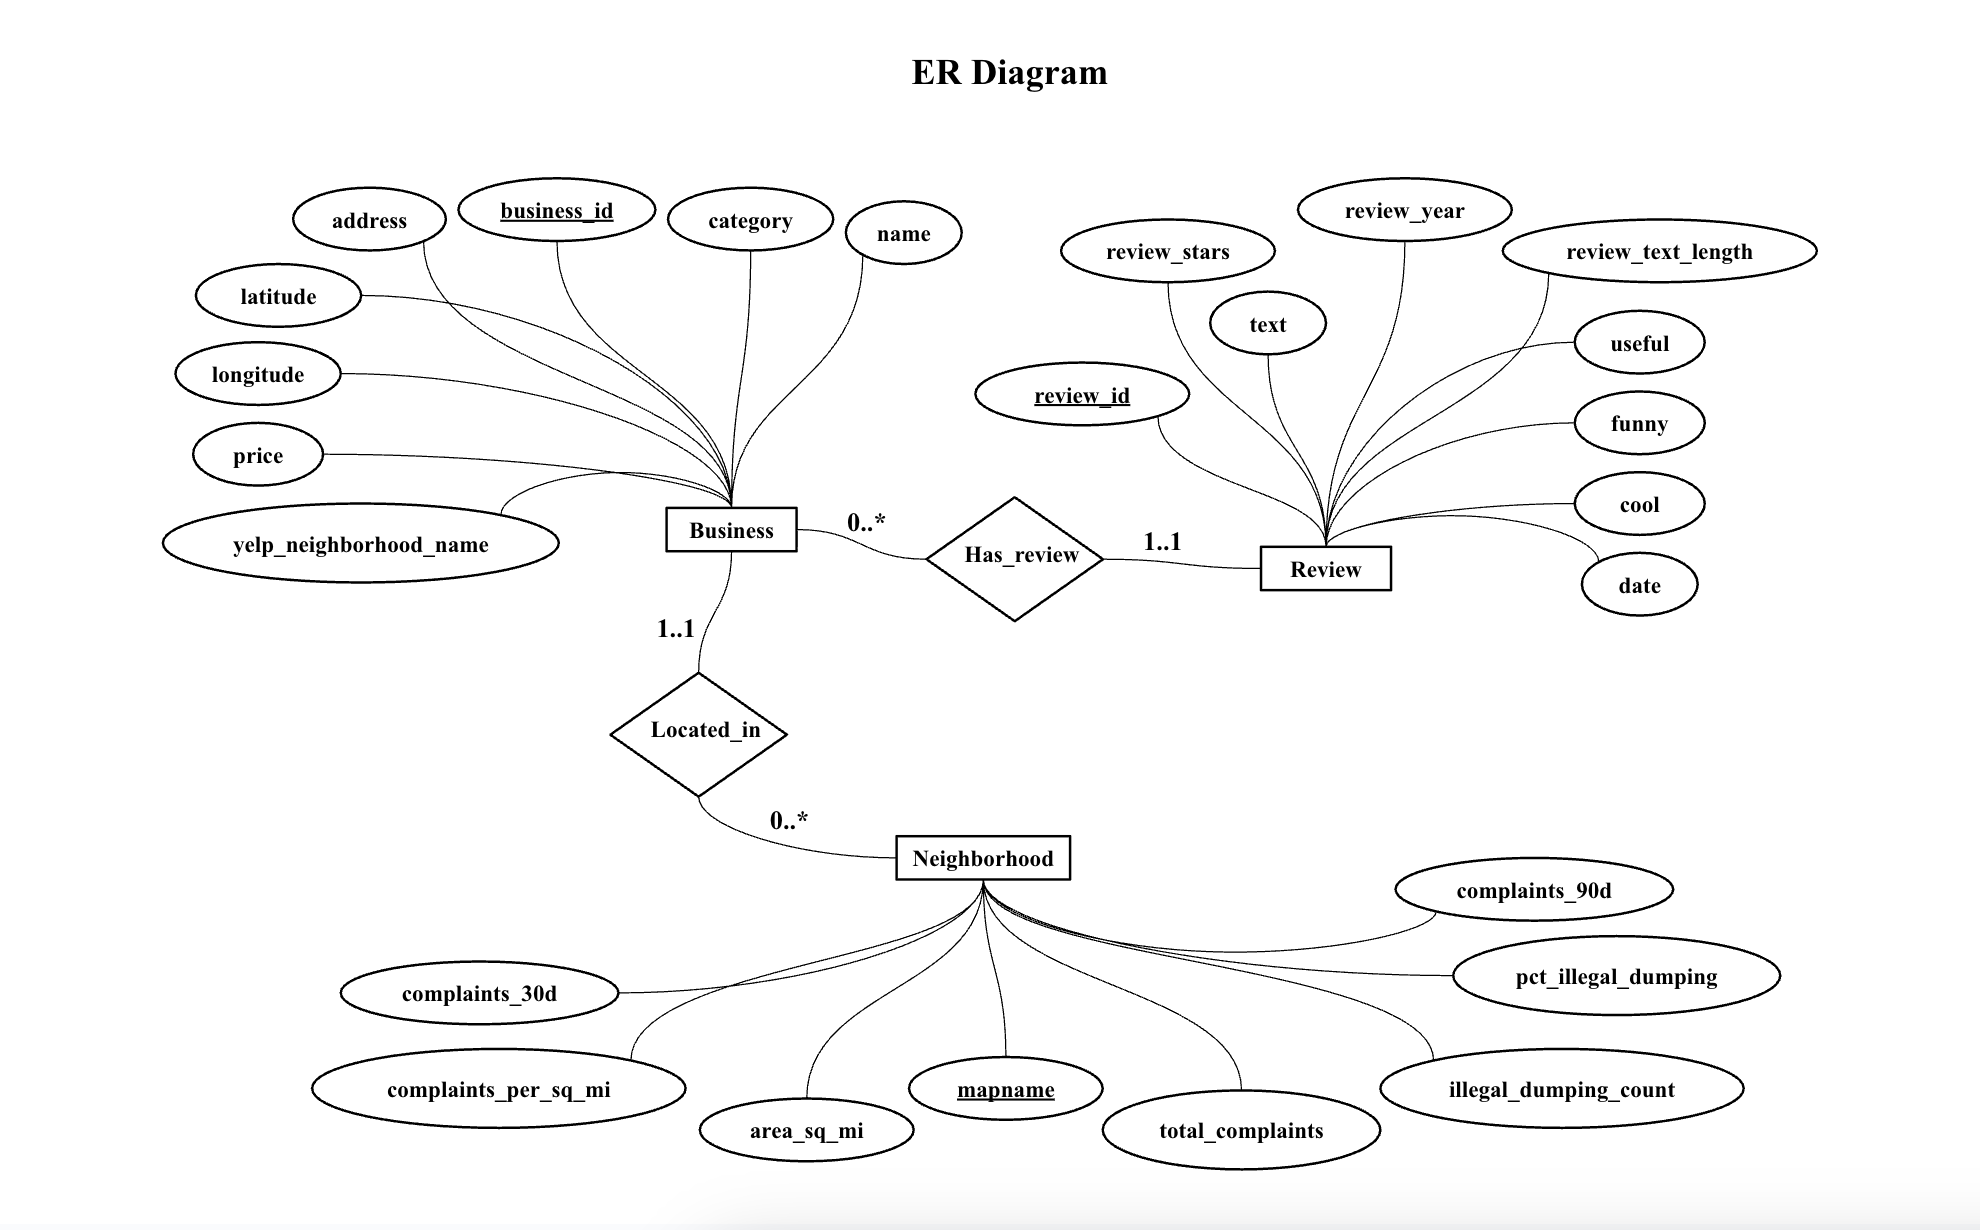

### Section 4.2 Merging Reviews, Business Attributes, and Cleanliness Features

We now take the review-with-neighborhood table and attach the neighborhood cleanliness features computed in Section 3 so that each row represents a single review with both restaurant-level and neighborhood-level predictors.

In [33]:
# Merge review-level data with neighborhood cleanliness features
model_df = review_with_neighborhood.merge(
    cleanliness_features,
    on="neighborhood_id",
    how="inner"
)

n_reviews_before = len(review_with_neighborhood)
n_reviews_after = len(model_df)
pct_with_cleanliness = (n_reviews_after / n_reviews_before) * 100

print(f"Reviews before merging cleanliness features: {n_reviews_before:,}")
print(f"Reviews after merging cleanliness features:  {n_reviews_after:,}")
print(f"Percentage of reviews with cleanliness features: {pct_with_cleanliness:.2f}%")


Reviews before merging cleanliness features: 686,169
Reviews after merging cleanliness features:  686,169
Percentage of reviews with cleanliness features: 100.00%


In [34]:
model_df.head()

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date,name,...,area_sq_mi_x,latitude,longitude,total_complaints,illegal_dumping_count,pct_illegal_dumping,complaints_30d,complaints_90d,area_sq_mi_y,complaints_per_sq_mi
0,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,5.022426,40.079848,-75.025080,113,36.0,0.318584,2.0,2.0,5.022426,22.499086
1,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,Dmitri's,...,0.405317,39.938013,-75.148131,4300,783.0,0.182093,31.0,144.0,0.405317,10608.981186
2,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4.0,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,LaScala's,...,0.767255,39.949529,-75.152139,3241,858.0,0.264733,34.0,102.0,0.767255,4224.150813
3,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5.0,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,Rittenhouse Grill,...,0.893491,39.948949,-75.169532,8684,1897.0,0.218448,87.0,275.0,0.893491,9719.184497
4,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5.0,0,0,0,My absolute favorite cafe in the city. Their b...,2014-11-12 15:30:27,Good Karma Cafe,...,0.558969,39.944609,-75.157833,6621,2088.0,0.315360,77.0,218.0,0.558969,11845.023199


All 686,169 reviews successfully merged with neighborhood cleanliness metrics, giving us a modeling dataset with complete restaurant, neighborhood, and 311-based environmental features for every review. This gives us a complete review-level modeling table with no missing neighborhood cleanliness information.

### Section 4.3: Initial Checks on the Modeling Dataset

Before running any predictive modeling, we perform a few basic checks to confirm that the merged review level dataset is complete, well formed, and contains reasonable values for both Yelp review attributes and neighborhood cleanliness features.

#### 4.3.1 Review-Level Completeness

We first confirm the total number of reviews included in the final modeling dataset.

In [35]:
total_reviews = len(model_df)
print(f"Total Reviews in Modeling Dataset: {total_reviews:,}")

Total Reviews in Modeling Dataset: 686,169


The final modeling dataset contains 686,169 reviews, confirming that all matched review records carried through successfully into the modeling ready table.

#### 4.3.2 Neighborhood Coverage

Next, we verify how many unique neighborhoods appear in the final review-level data.

In [36]:
num_neighborhoods = model_df['neighborhood_id'].nunique()
print(f"Unique Neighborhoods Represented: {num_neighborhoods}")

Unique Neighborhoods Represented: 148


The modeling dataset includes reviews from 148 distinct neighborhoods, indicating that nearly all areas of the city with restaurants are represented in our final analysis.

#### 4.3.3 Mean Review Rating by Neighborhood

This quick aggregation helps check whether review ratings look reasonable across neighborhoods.

In [37]:
mean_stars_by_neighborhood = (
    model_df.groupby('neighborhood_id')['review_stars']
            .mean()
            .sort_values(ascending=False)
)

mean_stars_by_neighborhood.head(10)

,review_stars
neighborhood_id,
Fitler Square,4.328000
East Park,4.229602
Mantua,4.191710
Old Kensington,4.171004
Point Breeze,4.145894
East Kensington,4.142857
Dickinson Narrows,4.130663
Strawberry Mansion,4.117647
Bella Vista,4.112352


The distribution looks reasonable, with most neighborhoods clustering around the low to mid 4 star range and none showing implausibly extreme averages. Neighborhoods like Fitler Square and East Park land at the higher end, but still within a realistic window, suggesting that the neighborhood-level rating patterns look consistent and as expected.


#### 4.3.4 Basic Summary of Cleanliness Features

These descriptive statistics confirm that cleanliness-related variables were merged correctly and exhibit meaningful variation.

In [38]:
cleanliness_summary = model_df[
    ['total_complaints', 'illegal_dumping_count',
     'pct_illegal_dumping', 'complaints_30d',
     'complaints_90d', 'complaints_per_sq_mi']
].describe()

cleanliness_summary

,total_complaints,illegal_dumping_count,pct_illegal_dumping,complaints_30d,complaints_90d,complaints_per_sq_mi
count,686169.000000,686169.00000,686169.000000,686169.000000,686169.000000,686169.000000
mean,4830.102498,1203.87862,0.251997,52.528105,159.113399,7410.579339
std,2881.848564,825.11194,0.089900,33.325131,106.075373,5017.503355
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.408898
25%,2155.000000,538.00000,0.218448,28.000000,70.000000,2371.060799
50%,4300.000000,985.00000,0.249652,42.000000,124.000000,9467.208618
75%,7662.000000,1897.00000,0.301191,87.000000,275.000000,10267.826459
max,13666.000000,5373.00000,0.764706,148.000000,512.000000,18897.510758


These summary statistics show that the cleanliness variables span wide but plausible ranges, with no obvious outliers or structural issues. Counts and recent window complaints scale the way we expect across neighborhoods and the illegal dumping share is roughly 25% on average, which suggests that the engineered cleanliness features behave consistently and were merged correctly.

#### 4.3.5 Star Rating Distribution

A simple distribution check to ensure the target variable is valid and not skewed in unexpected ways.

In [39]:
model_df['review_stars'].value_counts().sort_index()

,count
review_stars,
1.0,66299
2.0,57309
3.0,91527
4.0,194154
5.0,276880


The star rating distribution looks reasonable, with most reviews clustering at 4 and 5 stars and smaller but still meaningful counts at the lower ratings. This pattern matches typical Yelp behavior and suggests the target variable is behaving as expected.

## Section 5: Exploratory Data Analysis (EDA)

In this section, we summarize key distributions and relationships in the merged Yelp–311 dataset to check data quality and build intuition for later modeling.

### Section 5.1 Overview of Dataset Structure

#### 5.1.1 Data Types and Key Variables

We inspect the primary modeling dataset (model_df) to understand the structure of numerical and categorical features.

In [40]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686169 entries, 0 to 686168
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   review_id              686169 non-null  object 
 1   user_id                686169 non-null  object 
 2   business_id            686169 non-null  object 
 3   review_stars           686169 non-null  float64
 4   useful                 686169 non-null  int64  
 5   funny                  686169 non-null  int64  
 6   cool                   686169 non-null  int64  
 7   text                   686169 non-null  object 
 8   date                   686169 non-null  object 
 9   name                   686169 non-null  object 
 10  business_avg_stars     686169 non-null  float64
 11  review_count           686169 non-null  int64  
 12  price                  665401 non-null  float64
 13  categories             686169 non-null  object 
 14  neighborhood_id        686169 non-nu

This output shows that your dataset contains 686,169 Yelp reviews with 26 columns spanning review text, user/business identifiers, restaurant attributes, and neighborhood-level cleanliness metrics. Most fields are complete with minimal missingness and only the price column has some nulls.

#### 5.1.2 Summary Statistics

In [41]:
model_df.describe(include='all')

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date,name,...,area_sq_mi_x,latitude,longitude,total_complaints,illegal_dumping_count,pct_illegal_dumping,complaints_30d,complaints_90d,area_sq_mi_y,complaints_per_sq_mi
count,686169,686169,686169,686169.000000,686169.000000,686169.000000,686169.000000,686169,686169,686169,...,686169.000000,686169.000000,686169.000000,686169.000000,686169.00000,686169.000000,686169.000000,686169.000000,686169.000000,686169.000000
unique,686169,209095,5826,NaN,NaN,NaN,NaN,684959,684970,5058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,cACxcUY_AIsQKkpDRXuqnw,ET8n-r7glWYqZhuR6GcdNw,ytynqOUb3hjKeJfRj5Tshw,NaN,NaN,NaN,NaN,Omg!There's food was good!Ryan is awesome away...,2014-01-18 16:39:53,Reading Terminal Market,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,929,5778,NaN,NaN,NaN,NaN,7,5,5778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,3.813221,1.102027,0.370715,0.550697,NaN,NaN,NaN,...,1.160815,39.961365,-75.160146,4830.102498,1203.87862,0.251997,52.528105,159.113399,1.160815,7410.579339
std,NaN,NaN,NaN,1.306024,2.532593,1.430611,1.851121,NaN,NaN,NaN,...,1.292001,0.035468,0.035352,2881.848564,825.11194,0.089900,33.325131,106.075373,1.292001,5017.503355
min,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.078124,39.873796,-75.272689,1.000000,0.00000,0.000000,0.000000,0.000000,0.078124,0.408898
25%,NaN,NaN,NaN,3.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.482426,39.947327,-75.171477,2155.000000,538.00000,0.218448,28.000000,70.000000,0.482426,2371.060799
50%,NaN,NaN,NaN,4.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,...,0.767255,39.950917,-75.161765,4300.000000,985.00000,0.249652,42.000000,124.000000,0.767255,9467.208618
75%,NaN,NaN,NaN,5.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,...,1.137441,39.960971,-75.149838,7662.000000,1897.00000,0.301191,87.000000,275.000000,1.137441,10267.826459


This summary shows that review ratings average around 3.8 stars, with most reviews marked as not useful/funny/cool and only a few receiving high engagement which shows strong skew. Cleanliness metrics and restaurant activity measures (complaints_per_sq_mi, total_complaints, review_count) also exhibit large spreads and long right tails which means there is substantial variability across neighborhoods and businesses.

### Section 5.2: Distribution of Review Ratings

We will examine the distribution of individual Yelp review ratings (review_stars) to understand how skewed the target variable is and whether it behaves as we would expect for Yelp data.

#### 5.2.1 Histogram of Review Ratings

We plot a simple histogram of review_stars using integer bins from 1 to 5.

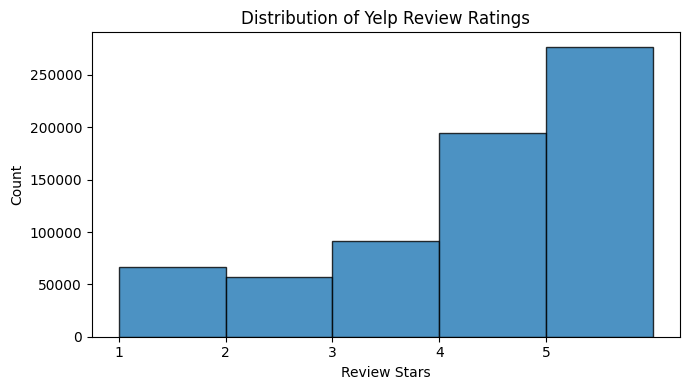

In [42]:
# Histogram of Review Ratings
plt.figure(figsize=(7, 4))
plt.hist(
    model_df["review_stars"],
    bins=[1, 2, 3, 4, 5, 6],  # 5 bins centered on star values
    edgecolor="black",
    alpha=0.8,
)
plt.title("Distribution of Yelp Review Ratings")
plt.xlabel("Review Stars")
plt.ylabel("Count")
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()

#### 5.2.2 Star Rating Counts

We tabulate how many reviews fall into each star level.

In [43]:
review_star_counts = (
    model_df["review_stars"]
    .value_counts()
    .sort_index()
    .rename("count")
)
review_star_counts

,count
review_stars,
1.0,66299
2.0,57309
3.0,91527
4.0,194154
5.0,276880


#### 5.2.3 Interpretation

The histogram and frequency table reveal a strong skew toward higher Yelp ratings. 5 star reviews are by far the most common, followed by 4 star reviews, while 3 star ratings appear noticeably less often. 1 star and 2 star reviews are relatively rare in comparison. This pattern reflects typical user behavior since highly satisfied customers are more likely to leave feedback than unhappy ones. The distribution is realistic for Yelp data, but the heavy concentration of observations at the upper end of the scale is important for modeling, since it limits variation in the target and may constrain how well prediction models can separate rating levels.

### Section 5.3 Additional Yelp-Level Distributions

#### 5.3.1 Histogram of Review Text Length

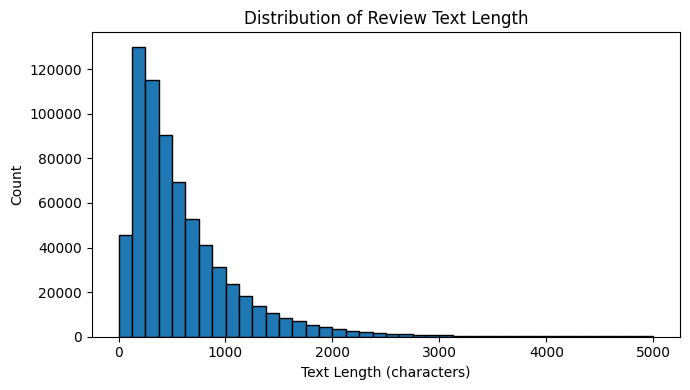

In [44]:
# create column
model_df["review_text_length"] = model_df["text"].str.len()

# plots histogram
plt.figure(figsize=(7,4))
plt.hist(model_df["review_text_length"], bins=40, edgecolor="black")
plt.title("Distribution of Review Text Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The distribution of review text length is right skewed, with most reviews clustered under 1,000 characters and a long tail of much longer reviews extending beyond 3,000 characters. This indicates that while short and medium length reviews dominate the dataset, a small number of very long reviews introduce substantial variability in text length.

#### 5.3.2 Histogram of Business Average Rating

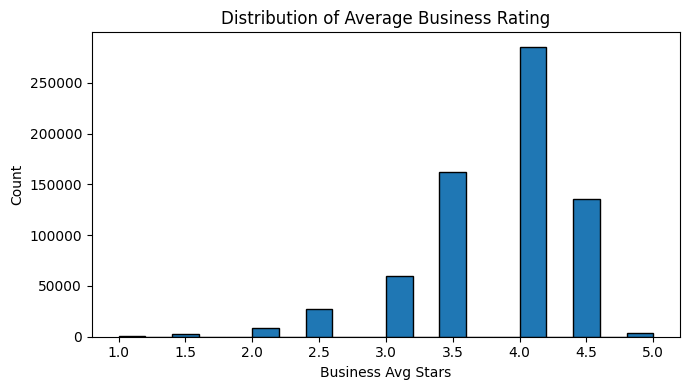

In [45]:
# Histogram of Business Average Rating
plt.figure(figsize=(7,4))
plt.hist(model_df["business_avg_stars"], bins=20, edgecolor="black")
plt.title("Distribution of Average Business Rating")
plt.xlabel("Business Avg Stars")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The distribution of business level average ratings is left skewed. Most restaurants cluster between roughly 3.5 and 4.5 stars, indicating that the majority maintain solid long term reputations. Very low rated businesses are rare, forming a sparse left tail that reflects only a small fraction of establishments. This distribution suggests that business level quality on Yelp tends to be stable and consistently positive.

#### 5.3.3 Distribution of Price Levels

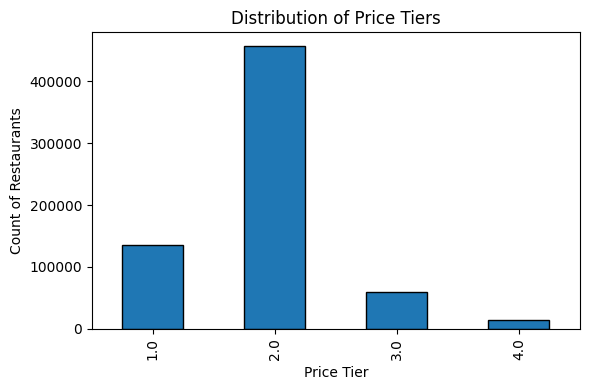

In [46]:
# Distribution of Price Levels
plt.figure(figsize=(6,4))
model_df["price"].value_counts().sort_index().plot(
    kind="bar",
    edgecolor="black"
)
plt.title("Distribution of Price Tiers")
plt.ylabel("Count of Restaurants")
plt.xlabel("Price Tier")
plt.tight_layout()
plt.show()

The distribution of price tiers is heavily concentrated in the mid-range, with tier 2 being by far the most common and tier 1 also accounting for a substantial share. Higher-end restaurants (tiers 3 and 4) are much less frequent, indicating that most reviewed restaurants in the dataset fall into affordable or moderately priced categories.

### Section 5.4 Outliers

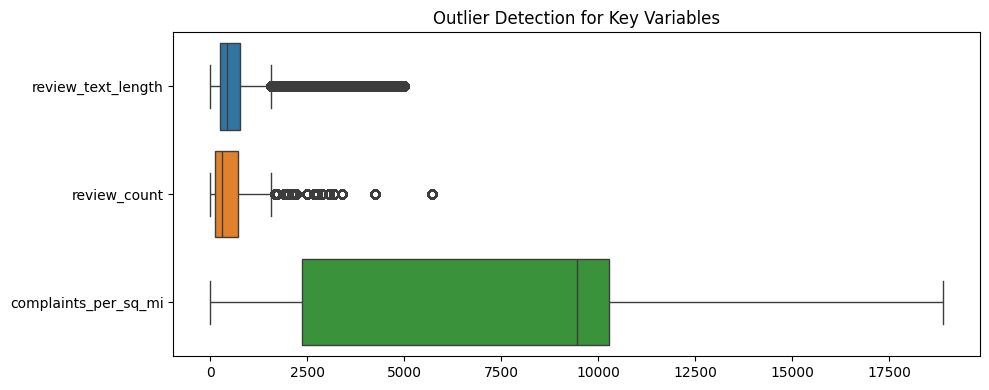

In [47]:
# Outlier Boxplot
numeric_cols = ["review_text_length", "review_count", "complaints_per_sq_mi"]
plt.figure(figsize=(10,4))
sns.boxplot(data=model_df[numeric_cols], orient="h")
plt.title("Outlier Detection for Key Variables")
plt.tight_layout()
plt.show()

The boxplots show strong right skew in all three variables, with many extreme high end values. Review text length has a long tail of very lengthy reviews, review_count includes businesses with exceptionally large volumes of ratings, and complaints_per_sq_mi varies widely with some neighborhoods experiencing extremely high complaint density. These points represent real structural variation rather than data errors, which means that scaling and transformation are important for any model that is sensitive to feature magnitude or outlier influence.

### Section 5.5 Correlation Structure

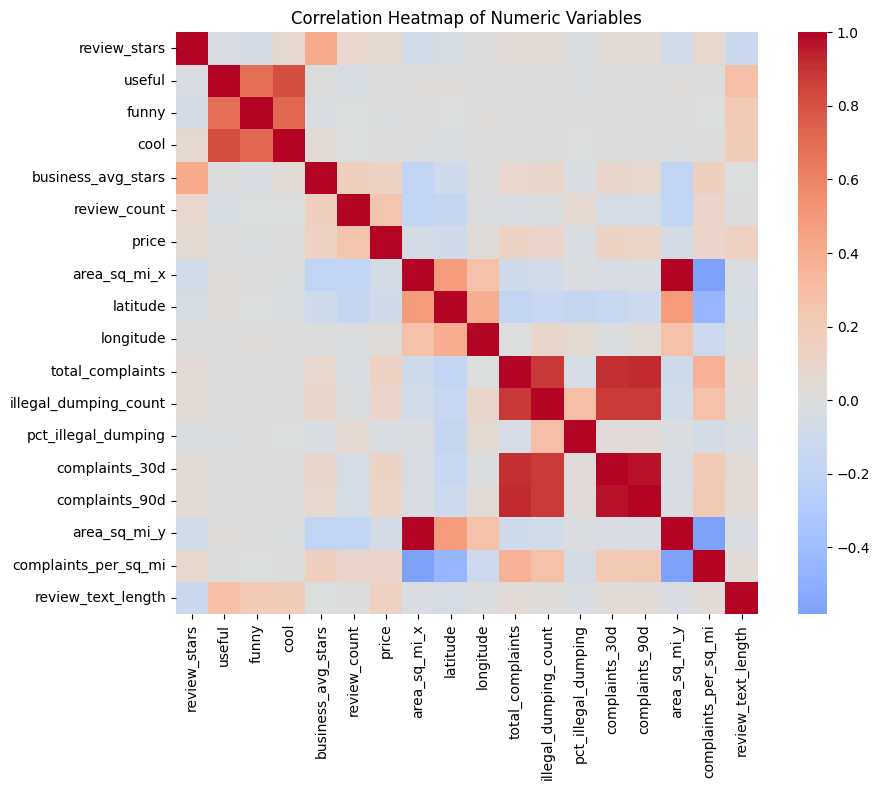

In [48]:
# Select only numeric columns for correlation
numeric_df = model_df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
corr_matrix = numeric_df.corr()

sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
)
plt.title("Correlation Heatmap of Numeric Variables")
plt.tight_layout()
plt.show()

The heatmap shows that Yelp engagement metrics (useful, funny, cool) are strongly related to one another, and cleanliness metrics are also tightly clustered. However, review ratings have almost no meaningful correlation with cleanliness features, suggesting that neighborhood conditions play only a small role in driving Yelp sentiment.

### Section 5.6 Distribution of Cleanliness Metrics

To understand how neighborhood cleanliness varies across Philadelphia, we examine the distributions of key 311-based features. These plots help identify skew, outliers, and whether additional transformations may be needed before modeling.

#### 5.6.1 Histogram: Total 311 Complaints per Neighborhood

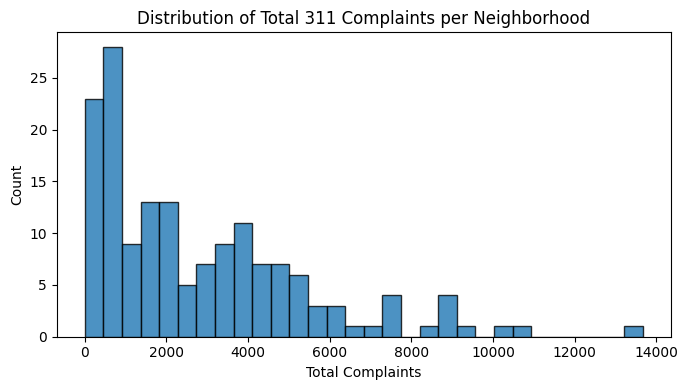

In [49]:
# Histogram: Total 311 Complaints per Neighborhood
plt.figure(figsize=(7,4))
plt.hist(
    cleanliness_features["total_complaints"],
    bins=30,
    edgecolor="black",
    alpha=0.8
)
plt.title("Distribution of Total 311 Complaints per Neighborhood")
plt.xlabel("Total Complaints")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### 5.6.2 Histogram: Complaints per Square Mile

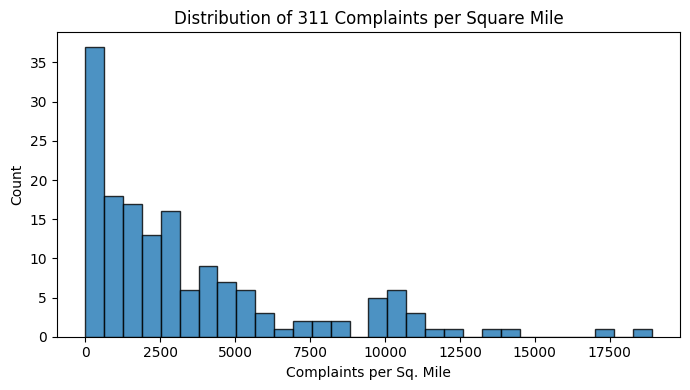

In [50]:
# Histogram: Complaints per Square Mile
plt.figure(figsize=(7,4))
plt.hist(
    cleanliness_features["complaints_per_sq_mi"],
    bins=30,
    edgecolor="black",
    alpha=0.8
)
plt.title("Distribution of 311 Complaints per Square Mile")
plt.xlabel("Complaints per Sq. Mile")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### 5.6.3 Histogram: Percent of Complaints that are Illegal Dumping

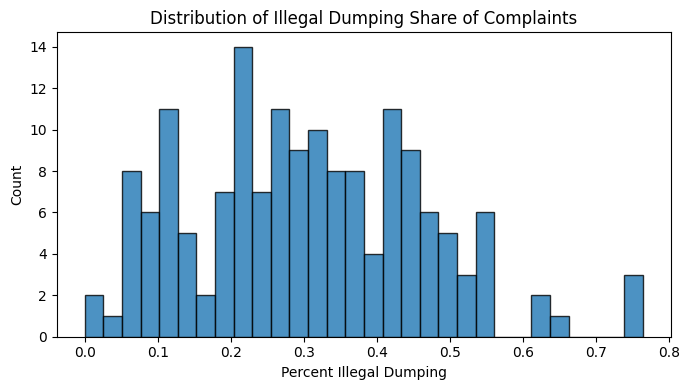

In [51]:
# Histogram: Percent of Complaints that are Illegal Dumping
plt.figure(figsize=(7,4))
plt.hist(
    cleanliness_features["pct_illegal_dumping"],
    bins=30,
    edgecolor="black",
    alpha=0.8
)
plt.title("Distribution of Illegal Dumping Share of Complaints")
plt.xlabel("Percent Illegal Dumping")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### 5.6.4 Interpretation

The distribution of total 311 complaints is right skewed, with most neighborhoods reporting only a few thousand complaints and a smaller group reaching into the 10k–14k range. These high volume areas stand out and may have an outsized impact on modeling if not handled carefully.

The distribution of complaints per square mile is even more skewed. Many neighborhoods have relatively low complaint density, while a few compact, high density areas show extremely high rates. This reinforces the importance of normalizing by land area when comparing neighborhoods.

The distribution of the percent of illegal dumping complaints is more balanced, with most neighborhoods falling between roughly 20% and 40%, though several exceed 50%. This suggests that illegal dumping is a much more prominent issue in certain areas than in others.

### 5.7 Relationship Between Review Ratings and Cleanliness Metrics

We examine whether neighborhood cleanliness shows any visible relationship with Yelp review ratings. We use simple scatterplots and boxplots to visualize how review_stars vary with key cleanliness indicators.

#### 5.7.1 Scatterplot: Review Rating vs. Complaints per Square Mile

We first compare individual review ratings against the neighborhood-level density of 311 complaints.

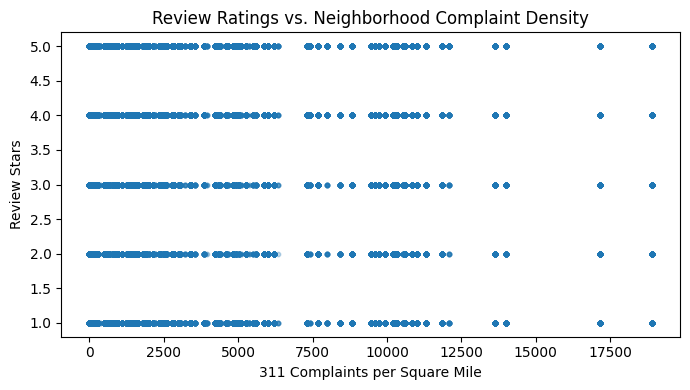

In [52]:
# Scatterplot: Review Rating vs. Complaints per Square Mile
plt.figure(figsize=(7, 4))
plt.scatter(
    model_df["complaints_per_sq_mi"],
    model_df["review_stars"],
    alpha=0.15,
    s=10,
)
plt.xlabel("311 Complaints per Square Mile")
plt.ylabel("Review Stars")
plt.title("Review Ratings vs. Neighborhood Complaint Density")
plt.tight_layout()
plt.show()

#### 5.7.2 Boxplot: Ratings Across Cleanliness Quartiles

To reduce noise from the large number of points, we bin neighborhoods into quartiles based on complaint density and compare rating distributions.

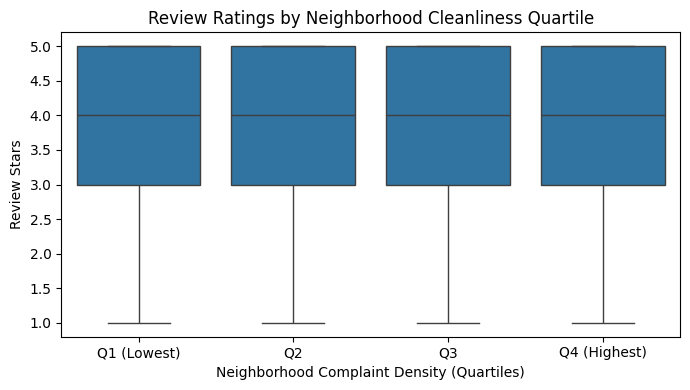

In [53]:
# Construct cleanliness quartiles
model_df["complaints_density_qtile"] = pd.qcut(
    model_df["complaints_per_sq_mi"], q=4, labels=["Q1 (Lowest)", "Q2", "Q3", "Q4 (Highest)"]
)

# Boxplot: Ratings Across Cleanliness Quartiles
plt.figure(figsize=(7, 4))
sns.boxplot(
    x="complaints_density_qtile",
    y="review_stars",
    data=model_df,
)
plt.xlabel("Neighborhood Complaint Density (Quartiles)")
plt.ylabel("Review Stars")
plt.title("Review Ratings by Neighborhood Cleanliness Quartile")
plt.tight_layout()
plt.show()

#### 5.7.3 Scatterplot: Review Rating vs. Illegal Dumping Share

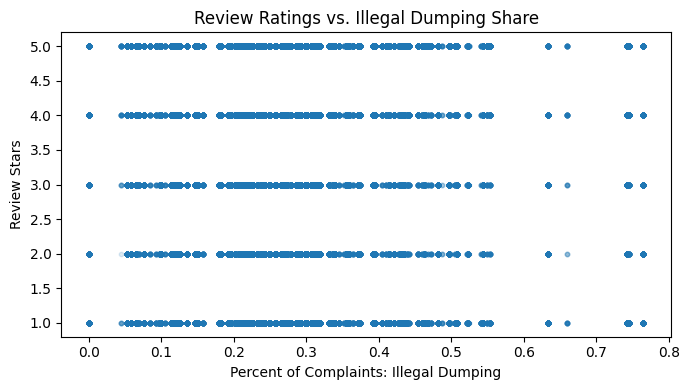

In [54]:
# Scatterplot: Review Rating vs. Illegal Dumping Share
plt.figure(figsize=(7, 4))
plt.scatter(
    model_df["pct_illegal_dumping"],
    model_df["review_stars"],
    alpha=0.15,
    s=10,
)
plt.xlabel("Percent of Complaints: Illegal Dumping")
plt.ylabel("Review Stars")
plt.title("Review Ratings vs. Illegal Dumping Share")
plt.tight_layout()
plt.show()

#### 5.7.4 Interpretation

The scatterplot of review ratings versus complaint density shows no clear downward trend. High density neighborhoods still receive many 4 and 5 star reviews, and although a few very dense areas produce more low-star reviews, the overall pattern is flat. This suggests that cleanliness by itself does not strongly influence review sentiment.

The boxplots across cleanliness quartiles reinforce this point. The median rating remains at 4 stars in every quartile, and the overall spread is nearly identical across groups. Even neighborhoods with the highest complaint density (Q4) look very similar to the cleanest neighborhoods, indicating that differences in environmental conditions do not lead to major shifts in customer satisfaction.

The scatterplot of illegal dumping share versus review ratings shows slightly more variation but still no systematic relationship. Neighborhoods with higher dumping shares include both highly rated and poorly rated restaurants. This suggests that review sentiment is primarily driven by restaurant-level qualities rather than neighborhood sanitation, and that cleanliness features on their own are likely weak predictors.

### Section 5.8: Spatial Visualization of Neighborhood Cleanliness

We finish the EDA by mapping neighborhood-level cleanliness. Choropleth maps make it easy to see how complaint density varies across space and where potential hotspots of sanitation issues appear.

#### 5.8.1 Choropleth of 311 Complaint Density

We first map complaints_per_sq_mi for each neighborhood using the cleaned neighborhood GeoDataFrame.

<Figure size 800x600 with 0 Axes>

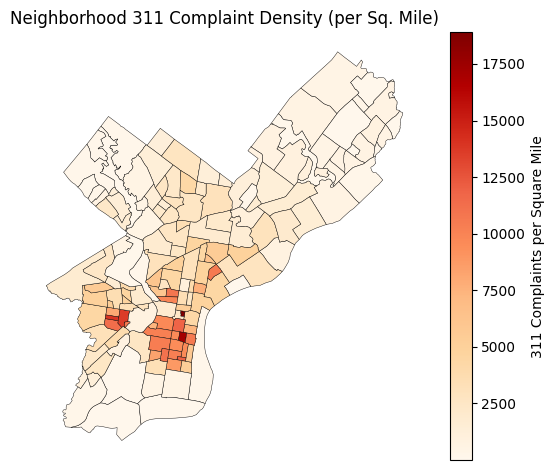

In [55]:
# Work in geographic coordinates
neighborhoods_clean_gdf = neighborhoods_clean_gdf.to_crs(epsg=4326)

plt.figure(figsize=(8, 6))
ax = neighborhoods_clean_gdf.plot(
    column="complaints_per_sq_mi",
    cmap="OrRd",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "311 Complaints per Square Mile"}
)

ax.set_axis_off()
ax.set_title("Neighborhood 311 Complaint Density (per Sq. Mile)", fontsize=12)
plt.tight_layout()
plt.show()


#### 5.8.2 Choropleth of Average Review Rating

<Figure size 800x600 with 0 Axes>

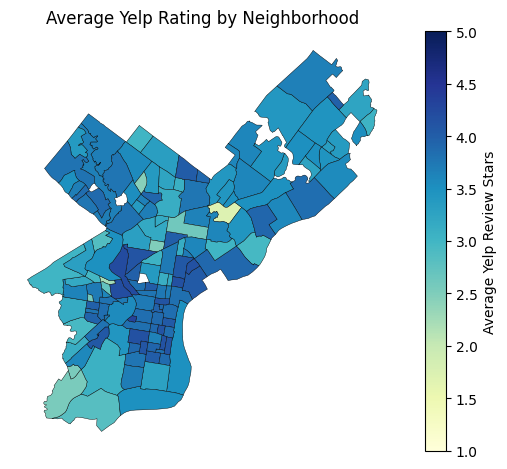

In [56]:
# Compute average review rating per neighborhood
neighborhood_avg_rating = (
    model_df.groupby("neighborhood_id")["review_stars"]
            .mean()
            .reset_index()
            .rename(columns={"review_stars": "avg_review_stars"})
)

# Merge onto neighborhood polygons
neighborhoods_with_ratings_gdf = neighborhoods_clean_gdf.merge(
    neighborhood_avg_rating,
    left_on="MAPNAME", # neighborhood name in shapefile
    right_on="neighborhood_id", # neighborhood name in model_df
    how="left"
)

plt.figure(figsize=(8, 6))
ax = neighborhoods_with_ratings_gdf.plot(
    column="avg_review_stars",
    cmap="YlGnBu",
    linewidth=0.3,
    edgecolor="black",
    legend=True,
    vmin=1.0,
    vmax=5.0,
    legend_kwds={"label": "Average Yelp Review Stars"}
)

ax.set_axis_off()
ax.set_title("Average Yelp Rating by Neighborhood", fontsize=12)
plt.tight_layout()
plt.show()

#### 5.8.3 Interpretation

The choropleth map of 311 complaint density highlights a clear geographic pattern that neighborhoods near Center City and parts of South Philadelphia show the highest concentration of 311 complaints per square mile, while most outlying residential areas have far lower levels. This aligns with expectations since denser, more commercial neighborhoods tend to produce more sanitation and environmental complaints. The sharp contrast between the urban core and surrounding districts also shows that complaint density is primarily driven by density and land use intensity rather than neighborhood specific issues.

The choropleth map of average Yelp ratings shows a much more diffuse pattern. Most neighborhoods fall within a narrow band of moderately high ratings, and the spatial gradients are weak. Higher-rated clusters appear in several parts of the city, including Northwest, South, and some Center City neighborhoods, but the differences are subtle. Importantly, the areas with the highest complaint density do not consistently show lower Yelp ratings. This supports earlier findings that cleanliness indicators have limited influence on restaurant-level review sentiment and that spatial variation in ratings is relatively mild across the city.

### Secion 5.9 EDA Summary and Key Takeaways

Our EDA reveals a few clear patterns in our data. Yelp ratings lean heavily toward the positive end, with most reviews falling in the 4 star to 5 star range and relatively few truly negative ratings. At the business level, restaurants also tend to cluster around average ratings of 3.5 stars to 4.5 stars, and most fall into mid range price tiers. However, neighborhood cleanliness metrics show much wider variation since some areas generate only modest numbers of 311 complaints, while a handful of dense commercial neighborhoods account for extremely high volumes. Despite this geographic spread, we see only weak associations between cleanliness indicators and review sentiment. This suggests that restaurant specific factors matter far more for Yelp ratings than broader neighborhood conditions, which helps guide where modeling efforts should focus.

## Section 6: Data Preprocessing and Feature Engineering for Modeling

In this section, we formalize our prediction target and prepare a structured set of restaurant level, review level, and neighborhood cleanliness features for downstream modeling. Our preprocessing steps directly follow the patterns identified in the EDA, including skewed count distributions, correlated engagement and cleanliness metrics, and the imbalance of Yelp ratings.

### 6.1 Defining Target and Feature Groups

Our goal is to predict the star rating (1on a scale from 1 to 5) of an individual Yelp review using both restaurant attributes and neighborhood level cleanliness indicators.

#### 6.1.1 Target Variable

We use review_stars as the outcome variable, representing the 1–5 star rating for each individual review.

In [57]:
# Target variable: individual review rating (1–5 stars)
y = model_df["review_stars"].copy()

#### 6.1.2 Simple Review-Level Features

We construct a few lightweight review-level predictors based on the review text and timestamp.

In [58]:
# Length of review text
model_df["review_text_length"] = model_df["text"].str.len()

# Extract review year
model_df["review_year"] = pd.to_datetime(model_df["date"]).dt.year

#### 6.1.3 Feature Groups

We organize predictors into three groups: restaurant features, review features, and cleanliness features.
We do not include review_stars itself as a feature.

**Restaurant-level features**

In [59]:
# Restaurant-level features
restaurant_feature_cols = [
    "review_count",   # number of reviews for the business
    "price",          # price level
    "latitude",
    "longitude",
]


**Review-level features**

In [60]:
# Review-level features
review_feature_cols = [
    "useful",
    "funny",
    "cool",
    "review_text_length",
    "review_year",
]

**Neighborhood cleanliness features**

In [61]:
# Neighborhood cleanliness features
cleanliness_feature_cols = [
    "total_complaints",
    "illegal_dumping_count",
    "pct_illegal_dumping",
    "complaints_30d",
    "complaints_90d",
    "complaints_per_sq_mi",
]


We rely on complaints_per_sq_mi to normalize for neighborhood size, so we do not separately include area fields here.

#### 6.1.4 Assemble the Feature Matrix

Finally, we combine all feature groups into a single design matrix X.

Section 5.5 showed two main correlated groups of variables which are the Yelp engagement metrics (useful, funny, cool) and the cleanliness measures that combine complaint totals and complaint densities. Rather than dropping features, we keep all of them because the engagement metrics capture different types of user interactions, and the cleanliness variables distinguish between complaint volume and complaint intensity, which adds interpretive value. Since our modeling pipeline uses standardized predictors and regularized linear models, removing features is unnecessary.

In [62]:
# Combine feature groups
feature_cols = (
    restaurant_feature_cols
    + review_feature_cols
    + cleanliness_feature_cols
)

X = model_df[feature_cols].copy()
y = model_df["review_stars"].copy()

print(f"Number of observations: {X.shape[0]:,}")
print(f"Number of features: {X.shape[1]}")


Number of observations: 686,169
Number of features: 15


The feature matrix includes all 686,169 reviews in the dataset and 15 predictors spanning restaurant characteristics, review attributes, and neighborhood cleanliness.

### Section 6.2 Handling Missing Data

Before modeling, we address missingness in the feature matrix.

#### 6.2.1 Inspecting Missingness

We first check how many missing values are present across all features.

In [63]:
missing_counts = (
    X.isna()
     .sum()
     .rename("missing_count")
     .sort_values(ascending=False)
)

missing_counts


,missing_count
price,20768
review_count,0
latitude,0
longitude,0
useful,0
funny,0
cool,0
review_text_length,0
review_year,0
total_complaints,0


Price is the only feature that contains 20,768 missing values, while all other numeric features are fully populated.

#### 6.2.2 Imputation Strategy and Implementation

Our EDA showed that cleanliness counts are heavily right skewed, and missing values in these fields typically indicate that no complaints were recorded. However, variables such as price, review text length, and review_count have more meaningful central tendencies. Based on this, we use 0 imputation for cleanliness counts and median imputation for all remaining variables. Missing price values are set to the median tier which is tier 2, which aligns with our EDA finding that most restaurants fall into the mid range price category.

In [64]:
# Fill with 0 for olumns where missing values mean no activity
zero_impute_cols = [
    "total_complaints",
    "illegal_dumping_count",
    "complaints_30d",
    "complaints_90d",
    "complaints_per_sq_mi",
]

# Median imputation for other features
median_impute_cols = [col for col in X.columns if col not in zero_impute_cols]

X_clean = X.copy()

# Zero imputation for structural zeros
for col in zero_impute_cols:
    X_clean[col] = X_clean[col].fillna(0)

# Median imputation for continuous features with true missingness
for col in median_impute_cols:
    X_clean[col] = X_clean[col].fillna(X_clean[col].median())

# print
print("Total missing values after imputation:", X_clean.isna().sum().sum())


Total missing values after imputation: 0


All missing values have been successfully filled, so the feature matrix is now complete with no gaps. This ensures the model can be trained without errors related to missing data and keeps preprocessing simple going forward.

#### 6.2.3 Transforming Skewed Count Features

Our EDA revealed extreme right skew in several variables, including review_count, cleanliness counts, complaints per square mile, and review text length. To reduce the influence of these large outliers, we apply a log(1 + x) transformation to all count and density features.

In [65]:
# Log-transform highly skewed count and density features
log_transform_cols = [
    "review_count",
    "review_text_length",
    "total_complaints",
    "illegal_dumping_count",
    "complaints_30d",
    "complaints_90d",
    "complaints_per_sq_mi",
]

for col in log_transform_cols:
    X_clean[f"log_{col}"] = np.log1p(X_clean[col])

This improves stability for linear models and makes numerical scaling more meaningful.

### 6.3 Encoding & Scaling

We now encode the categorical price feature and standardize all numeric inputs so they are on comparable scales for modeling.

#### 6.3.1 Specify numeric and categorical columns

In [66]:
# Price tier is the only categorical variable
categorical_features = ["price"]

# Numeric features include coordinates, review behavior, and cleanliness metrics
numeric_features = [
    "latitude",
    "longitude",
    "useful",
    "funny",
    "cool",
    "review_year",
    "pct_illegal_dumping",
    # log-transformed variables
    "log_review_count",
    "log_review_text_length",
    "log_total_complaints",
    "log_illegal_dumping_count",
    "log_complaints_30d",
    "log_complaints_90d",
    "log_complaints_per_sq_mi",
]

#### 6.3.2 Build preprocessing transformer

In [67]:
# Standardize numeric features; one-hot encode categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Full preprocessing pipeline applied before each model
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

This preprocessor object will later be plugged into a full modeling pipeline so that scaling and encoding are applied consistently within cross-validation and on the test set.

### 6.4 Train / Test Split

Since multiple reviews come from the same restaurant, we need to split the data so that all reviews from a given business_id stay in the same fold to avoid data leakage, where the model gains information about a restaurant from the training set and appears to perform better on the test set than it actually does.

#### 6.4.1 Grouped split by business_id

In [68]:
# Use the fully cleaned feature matrix
X_full = X_clean

# Target variable and grouping key
y = model_df["review_stars"].values
groups = model_df["business_id"].values

# Group-aware train/test split to prevent leakage across reviews of the same business
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=15)

# Split
for train_idx, test_idx in gss.split(X_full, y, groups):
    X_train = X_full.iloc[train_idx].copy()
    X_test = X_full.iloc[test_idx].copy()
    y_train = y[train_idx]
    y_test = y[test_idx]

# Print
print(f"Training set size: {len(X_train):,}")
print(f"Test set size:      {len(X_test):,}")


Training set size: 547,832
Test set size:      138,337


After splitting, the training set has 547,832 reviews and the test set has 138,337 reviews.

#### 6.4.2 Addressing Outcome Imbalance

Based on the EDA, review ratings are heavily concentrated at 4 stars to 5 stars. Because we model review_stars as a numeric regression target rather than a classification label, we do not resample or reweight classes. The dataset still contains sufficient variability in lower star reviews, and error based evaluation metrics (MAE, RMSE) naturally reflect performance across the entire rating range.

## Section 7: Baseline Model with Yelp-Only Linear Regression

In this section, we build a baseline regression model that predicts individual review star ratings using only Yelp based restaurant and review features. This gives us a reference point before adding neighborhood cleanliness variables in later models.

### 7.1 Selecting Yelp-Only Features

We define a feature subset that includes only restaurant metadata, basic review engagement metrics, and temporal information. Cleanliness features are intentionally excluded at this stage to provide a fair baseline comparison later.

#### 7.1.1 Feature Subset for Baseline

In [69]:
# Yelp-only numeric and categorical features (log-transformed counts)
yelp_numeric_cols = [
    "log_review_count",
    "latitude",
    "longitude",
    "useful",
    "funny",
    "cool",
    "log_review_text_length",
    "review_year",
]

# Price tier encoded as a categorical feature
yelp_categorical_cols = ["price"]

# Subset training and test sets to Yelp-only predictors
X_train_yelp = X_train[yelp_numeric_cols + yelp_categorical_cols].copy()
X_test_yelp  = X_test[yelp_numeric_cols + yelp_categorical_cols].copy()

#### 7.1.2 Build Baseline Linear Regression Pipeline

In [70]:
# Preprocessing: scale numeric features and one-hot encode price tier
yelp_preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), yelp_numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), yelp_categorical_cols),
    ]
)

# Full pipeline: preprocessing + linear regression
baseline_lr = Pipeline(
    steps=[
        ("preprocess", yelp_preprocessor),
        ("model", LinearRegression()),
    ]
)

# Fit the baseline model
baseline_lr.fit(X_train_yelp, y_train);


### Section 7.2 Baseline Model Evaluation

#### 7.2.1 RMSE, MAE, and R²

We evaluate the baseline using RMSE, MAE, and R² on both train and test splits, then inspect the learned coefficients mapped back to feature names to see which Yelp features the linear model relies on most.

In [71]:
# Generate train and test predictions
y_train_pred = baseline_lr.predict(X_train_yelp)
y_test_pred  = baseline_lr.predict(X_test_yelp)

# Compute RMSE
baseline_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
baseline_test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred))

# Compute MAE
baseline_train_mae = mean_absolute_error(y_train, y_train_pred)
baseline_test_mae  = mean_absolute_error(y_test,  y_test_pred)

# Compute R-squared
baseline_train_r2 = r2_score(y_train, y_train_pred)
baseline_test_r2  = r2_score(y_test,  y_test_pred)

# Print summary stats
print("Baseline Yelp Only Linear Regression Performance:")
print()
print(f"Train RMSE: {baseline_train_rmse:.4f}")
print(f"Test  RMSE: {baseline_test_rmse:.4f}")
print()
print(f"Train MAE:  {baseline_train_mae:.4f}")
print(f"Test  MAE:  {baseline_test_mae:.4f}")
print()
print(f"Train R²:   {baseline_train_r2:.4f}")
print(f"Test  R²:   {baseline_test_r2:.4f}")

Baseline Yelp Only Linear Regression Performance:

Train RMSE: 1.2515
Test  RMSE: 1.2492

Train MAE:  1.0127
Test  MAE:  1.0096

Train R²:   0.0841
Test  R²:   0.0755


The baseline model performs almost identically on the training and test sets, which indicates it is not overfitting. An RMSE of about 1.25 on a 1 to 5 scale means predictions are typically off by just over one star, which is reasonable given how noisy individual review ratings are. The MAE values around 1.01 also show that the model is about one star away from the true rating on average. The R² values remain low around 0.08 on train and 0.07 on test, which means that Yelp only features explain only a small share of the variation in review ratings. This is expected because these features do not capture the full dining experience. The baseline model behaves as expected and provides a reliable benchmark for adding cleanliness features later.

#### 7.2.2 Predicted vs. Actual Ratings

To visualize how the baseline model performs across the 1–5 rating scale, we compare predicted ratings with actual test set ratings. This highlights where the linear model tends to overpredict or underpredict, especially at the extremes.

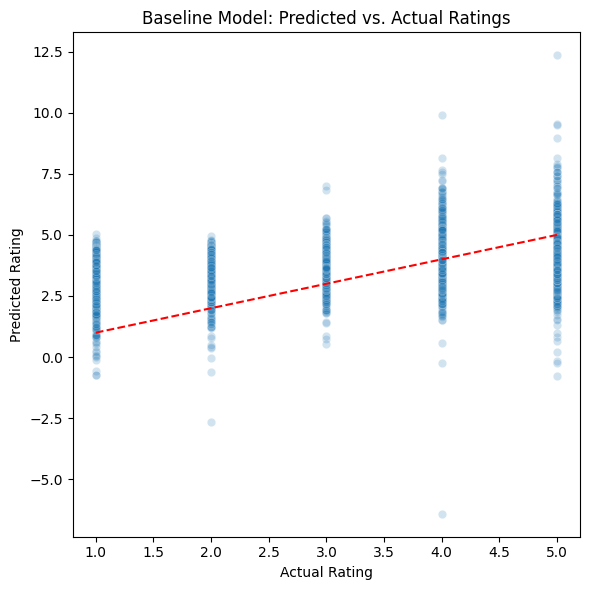

In [72]:
# Predicted vs Actual Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.2)
plt.plot([1, 5], [1, 5], color="red", linestyle="--")  # reference line

# Scatter of actual vs predicted ratings
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Baseline Model: Predicted vs. Actual Ratings")
plt.tight_layout()
plt.show()


The predicted vs actual scatterplot shows that the baseline linear model captures only a weak relationship between the true ratings and the model’s predictions. Each true rating forms a vertical band with wide variation in predicted values, meaning the model assigns very similar predictions to many different reviews. The shallow upward trend indicates that higher actual ratings tend to receive higher predictions on average, but the spread makes clear that Yelp-only features provide limited predictive power.

#### 7.2.3 Residual Distribution

We now look at the distribution of residuals whic is the actual minus the predicted. This helps reveal whether the model systematically overestimates or underestimates ratings.

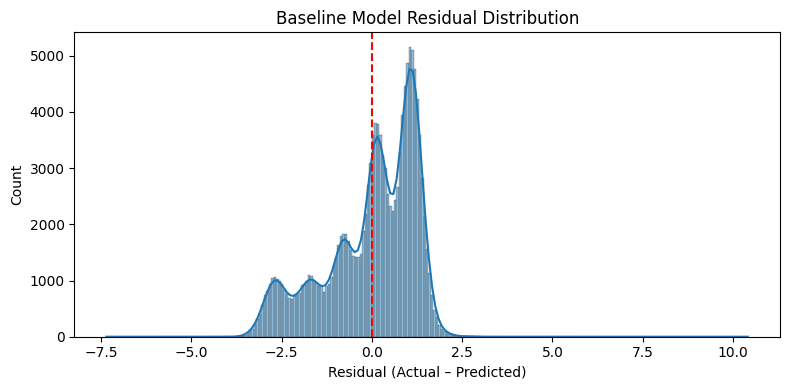

In [73]:
# Residual Distribution
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.axvline(0, color="red", linestyle="--")

plt.title("Baseline Model Residual Distribution")
plt.xlabel("Residual (Actual – Predicted)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


The residual plot reveals that most errors fall within roughly -2 to +2 stars, consistent with the MAE of about one star. The distribution is asymmetric, with a heavier left tail, meaning the model more often overpredicts ratings than underpredicts them. Multiple peaks reflect the discrete 1–5 rating structure. The pattern shows a model that is unbiased on average but struggles to capture the variability in individual review ratings.

### 7.3 Feature Importance Coefficient Analysis

We next inspect the learned coefficients to see which Yelp only features the linear model relies on most. Because all numeric predictors are standardized, coefficient magnitudes are comparable across features.

In [74]:
# Extract Linear Regression Coefficients
encoder = baseline_lr.named_steps["preprocess"]
model   = baseline_lr.named_steps["model"]

# Reconstruct feature names
feature_names = (
    yelp_numeric_cols
    + list(encoder.named_transformers_["cat"].get_feature_names_out(yelp_categorical_cols))
)

# Build coefficient dataframe
coef_df = (
    pd.DataFrame({
        "feature": feature_names,
        "coefficient": model.coef_
    })
    .sort_values(by="coefficient", ascending=False)
)

coef_df


,feature,coefficient
5,cool,0.453093
11,price_4.0,0.210043
0,log_review_count,0.164200
7,review_year,0.046003
10,price_3.0,0.043017
2,longitude,0.025152
1,latitude,-0.027348
8,price_1.0,-0.094589
9,price_2.0,-0.158471
6,log_review_text_length,-0.187870


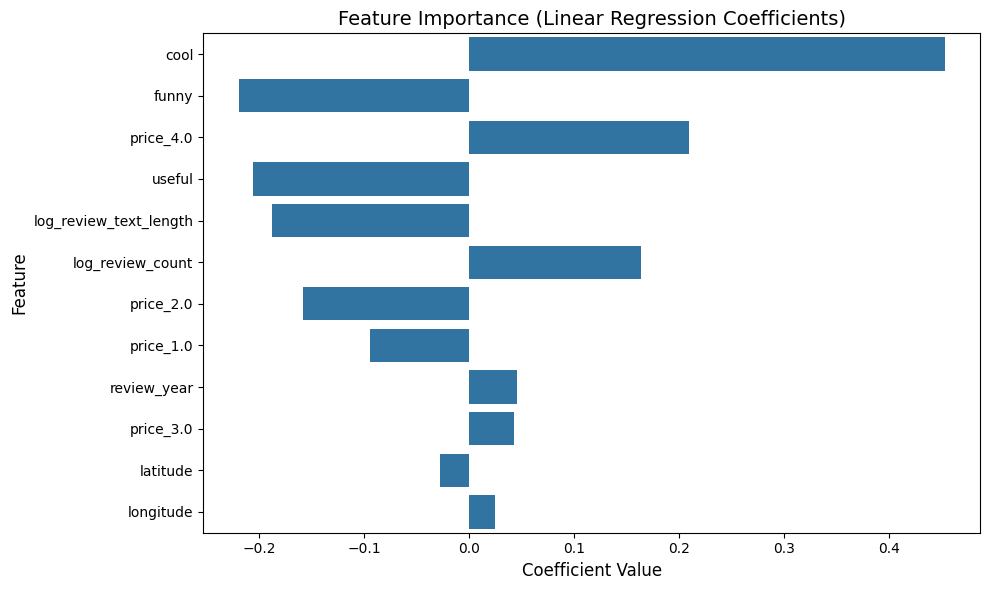

In [75]:
# Visualize coefficients

# Sort by absolute value to highlight strongest predictors
coef_df_sorted = coef_df.reindex(
    coef_df["coefficient"].abs().sort_values(ascending=False).index
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df_sorted,
    x="coefficient",
    y="feature",
)
plt.title("Feature Importance (Linear Regression Coefficients)", fontsize=14)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


**Interpretation**

1. cool = 0.4531 (largest positive effect)

Reviews marked as cool are strongly associated with higher star ratings. These reviews tend to reflect enthusiasm, novelty, or genuinely positive experiences, which explains why this engagement signal rises so sharply with rating. Its large coefficient suggests it is one of the clearest behavioral cues of satisfaction in the Yelp ecosystem.

2. price_4.0 = 0.2100

Restaurants in the most expensive price tier score substantially higher ratings on average. This aligns with expected quality differences, as high-end venues generally provide more consistent service and better overall experiences. The effect is meaningful and places price_4.0 as the second-strongest predictor.

3. log_review_count = 0.1642

A higher accumulated review count corresponds to slightly higher ratings, likely because established restaurants have smoothed out early inconsistencies and built a stable customer base. The effect is modest but consistent with the idea that popular, long-standing restaurants tend to deliver more reliable experiences.

4. price_3.0 = 0.0430

Mid to high priced restaurants also show a positive effect, though smaller than the $4 tier. This indicates that above average pricing is associated with better customer experiences, even if not at the very top end of the market.

5. review_year = 0.0460

Review ratings increase slightly in more recent years. This could reflect platform dynamics, such as shifts in user behavior toward more positive ratings, or a general improvement in the restaurant market. The effect is small but noticeable.

6. longitude = 0.0252

Longitude has only a negligible positive effect, suggesting there is no meaningful east to west gradient in Yelp ratings across Philadelphia. The coefficient is too small to imply substantive geographic differences.

7. latitude = −0.0273

Latitude exhibits a very small negative effect. This may loosely correspond to slight north to south variation in restaurant density or demographics, but the effect is extremely small and not substantively meaningful.

8. log_review_text_length = −0.1879

Longer reviews tend to have lower ratings. Users often write more when they are disappointed or have issues to explain, so length becomes a subtle indicator of dissatisfaction. This is one of the stronger negative predictors in the model.

9. price_2.0 = −0.1585

Restaurants in the $2 price tier receive slightly lower ratings compared to more expensive categories. This makes sense given greater variability in quality and consistency among lower-cost establishments. The effect is modest but directionally intuitive.

10. price_1.0 = −0.0946

The negative effect becomes stronger at the $1 tier, reflecting the challenges and inconsistency common in cheaper restaurants. These venues often face constraints that can affect service, food quality, or ambience.

11. useful = −0.2052

Useful reviews tend to accompany more detailed critiques or complaints, which explains the negative relationship. Users often mark reviews as useful when they highlight problems or describe shortcomings, so this variable captures a form of negative sentiment.

12. funny = −0.2194 (largest negative effect)

The strongest negative coefficient appears on funny. Humor, especially sarcastic or exaggerated commentary, is common in lower rated reviews, so this tag acts as a subtle signal of dissatisfaction. This makes it the most informative negative behavioral indicator in the feature set.

## Section 8 Integrated Model with Yelp + Cleanliness Features (XGBoost Regression)

In this section, we extend our baseline Yelp-only model by adding the neighborhood-level cleanliness indicators derived
from 311 sanitation complaints.

Our goal is to test whether these environmental features provide any incremental
predictive power for individual Yelp review ratings beyond restaurant and review attributes alone.


### Section 8.1 Define full feature set (Yelp + cleanliness)

In [76]:
# Numeric Yelp features
print("Yelp numeric features:", yelp_numeric_cols)

# Neighborhood cleanliness features
print("Cleanliness features:", cleanliness_feature_cols)

full_numeric_cols = yelp_numeric_cols + cleanliness_feature_cols
full_categorical_cols = ["price"]

X_train_full = X_train[full_numeric_cols + full_categorical_cols].copy()
X_test_full  = X_test[full_numeric_cols + full_categorical_cols].copy()

X_train_full.head()

Yelp numeric features: ['log_review_count', 'latitude', 'longitude', 'useful', 'funny', 'cool', 'log_review_text_length', 'review_year']
Cleanliness features: ['total_complaints', 'illegal_dumping_count', 'pct_illegal_dumping', 'complaints_30d', 'complaints_90d', 'complaints_per_sq_mi']


,log_review_count,latitude,longitude,useful,funny,cool,log_review_text_length,review_year,total_complaints,illegal_dumping_count,pct_illegal_dumping,complaints_30d,complaints_90d,complaints_per_sq_mi,price
0,5.204007,40.079848,-75.025080,1,0,1,5.497168,2015,113,36.0,0.318584,2.0,2.0,22.499086,2.0
1,5.613128,39.938013,-75.148131,1,2,1,5.834811,2015,4300,783.0,0.182093,31.0,144.0,10608.981186,2.0
2,5.908083,39.949529,-75.152139,0,0,0,5.170484,2009,3241,858.0,0.264733,34.0,102.0,4224.150813,2.0
4,5.521461,39.944609,-75.157833,0,0,0,6.040255,2014,6621,2088.0,0.315360,77.0,218.0,11845.023199,1.0
7,7.348588,39.951417,-75.173768,3,1,1,6.840547,2009,8684,1897.0,0.218448,87.0,275.0,9719.184497,2.0


### Section 8.2 Preprocessor for XGBoost

In [77]:
full_numeric_transformer = StandardScaler()
full_categorical_transformer = OneHotEncoder(handle_unknown="ignore")

full_preprocessor = ColumnTransformer(
    transformers=[
        ("num", full_numeric_transformer, full_numeric_cols),
        ("cat", full_categorical_transformer, full_categorical_cols),
    ]
)

### Section 8.3 Exploratory PCA Analysis

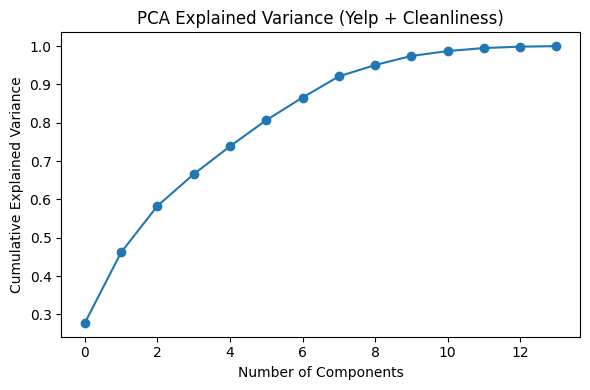

In [78]:
numeric_for_pca = full_numeric_cols

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full[numeric_for_pca])

pca = PCA(n_components=len(numeric_for_pca))
pca.fit(X_scaled)

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title("PCA Explained Variance (Yelp + Cleanliness)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.tight_layout()
plt.show()

The PCA curve shows that the first few components explain most of the variance in the
combined Yelp and cleanliness features. This makes sense because several Yelp
engagement variables are correlated with each other, and the same is true for the different
cleanliness indicators. After around eight components, the curve starts to flatten, which
suggests that the remaining components mainly capture smaller details in the data.

We do not use PCA as part of the predictive model since XGBoost can already handle
correlated predictors. The purpose here is mainly to check the overall structure of the
feature space and confirm that there is meaningful shared variation rather than noise.


### Section 8.4 XGBoost Model + RandomizedSearchCV

In [79]:
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    random_state=15,
    n_jobs=-1
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", full_preprocessor),
        ("model", xgb_base),
    ]
)

param_distributions = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [3, 5, 7, 9],
    "model__learning_rate": [0.03, 0.05, 0.1, 0.2],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
    "model__min_child_weight": [1, 5, 10],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=15,
)

print("Fitting XGBoost model with Yelp + cleanliness features...")
xgb_search.fit(X_train_full, y_train)

print("\nBest parameters found:")
xgb_search.best_params_

Fitting XGBoost model with Yelp + cleanliness features...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found:


{'model__subsample': 0.7,
 'model__n_estimators': 200,
 'model__min_child_weight': 10,
 'model__max_depth': 9,
 'model__learning_rate': 0.03,
 'model__colsample_bytree': 0.7}

### Section 8.5 Evaluate XGBoost Model



In [80]:
# Evaluate tuned XGBoost model on train / test sets
best_xgb = xgb_search.best_estimator_

y_train_pred_xgb = best_xgb.predict(X_train_full)
y_test_pred_xgb  = best_xgb.predict(X_test_full)

xgb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
xgb_test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))

xgb_train_mae = mean_absolute_error(y_train, y_train_pred_xgb)
xgb_test_mae  = mean_absolute_error(y_test, y_test_pred_xgb)

xgb_train_r2 = r2_score(y_train, y_train_pred_xgb)
xgb_test_r2  = r2_score(y_test, y_test_pred_xgb)

print("XGBoost (Yelp + Cleanliness) Performance\n")
print(f"Train RMSE: {xgb_train_rmse:.4f}")
print(f"Test  RMSE: {xgb_test_rmse:.4f}\n")

print(f"Train MAE:  {xgb_train_mae:.4f}")
print(f"Test  MAE:  {xgb_test_mae:.4f}\n")

print(f"Train R²:   {xgb_train_r2:.4f}")
print(f"Test  R²:   {xgb_test_r2:.4f}")

XGBoost (Yelp + Cleanliness) Performance

Train RMSE: 1.1462
Test  RMSE: 1.2128

Train MAE:  0.9170
Test  MAE:  0.9777

Train R²:   0.2317
Test  R²:   0.1286


### Section 8.6 Interpretation


The tuned XGBoost model provides noticeably better predictive performance than the baseline
Yelp-only linear regression model.

In terms of predictive accuracy, the integrated model achieves a test RMSE of 1.2128, an
improvement over the baseline RMSE of 1.2492. Test MAE also decreases from 1.0096 to
0.9777, and R² increases from roughly 0.08 to 0.13. While these improvements are not large
in absolute magnitude, they are consistent across metrics and represent a meaningful gain
given the high variability and inherent noise in individual Yelp review ratings.

The relatively small gap between training and test performance suggests that the model generalizes well and does not overfit despite the large feature set.
This is likely due to the combination of strong regularization and the substantial training
sample size.

Overall, the results show that adding neighborhood cleanliness indicators provides incremental
predictive value, though the effect is modest compared to restaurant-level and review-level
features. This pattern aligns with earlier exploratory analysis: Yelp ratings vary much more
with restaurant characteristics than with neighborhood sanitation conditions, and cleanliness
is best understood as a secondary rather than primary source of variation in review scores.

## Section 9 Random Forest Model with Yelp + Cleanliness

In this section, we introduce our third predictive model: a Random Forest Regressor trained on the same combined Yelp and cleanliness feature set.

The random forest gives us a complementary view of how non-linear models handle the combined Yelp and cleanliness features. Unlike XGBoost, which grows trees sequentially, the random forest averages many decorrelated trees built in parallel. Comparing the two helps us see which gains come specifically from boosting and which come from using flexible tree-based models more generally.

It also acts as a robustness check. If the random forest improves over the linear baseline as well, then the value of the cleanliness features is not tied to any single modeling choice.

To ensure comparability across all models, we apply the same training–test split and reuse the full_preprocessor introduced earlier.

### Section 9.1 Random Forest Pipeline and Hyperparameter Search

In [81]:
# base random forest model
rf_base = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=15,
)

# reuse the same full_preprocessor as in the XGBoost model
rf_pipeline = Pipeline(
    steps=[
        ("preprocess", full_preprocessor),
        ("model", rf_base),
    ]
)

rf_param_distributions = {
    "model__n_estimators": [200, 300, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [5, 10],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", 0.5],
    "model__bootstrap": [True],
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=8,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=15,
)

n_train = len(X_train_full)
subsample_size = min(30000, n_train)

rng = np.random.RandomState(15)
sub_idx = rng.choice(n_train, size=subsample_size, replace=False)

X_train_sub = X_train_full.iloc[sub_idx]
y_train_sub = y_train[sub_idx]

print(f"Fitting Random Forest hyperparameter search on a subsample of {subsample_size} rows...")
rf_search.fit(X_train_sub, y_train_sub);

print("\nBest Random Forest hyperparameters (from subsample):")
print(rf_search.best_params_)

# refit the best model on the full training set for final evaluation
best_rf = rf_search.best_estimator_
print("\nRefitting the best Random Forest model on the full training data...")
best_rf.fit(X_train_full, y_train);

Fitting Random Forest hyperparameter search on a subsample of 30000 rows...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Random Forest hyperparameters (from subsample):
{'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': True}

Refitting the best Random Forest model on the full training data...


### Section 9.2 Evaluation of the Random Forest Model

In [82]:
best_rf = rf_search.best_estimator_

# predictions on train and test sets
y_train_pred_rf = best_rf.predict(X_train_full)
y_test_pred_rf  = best_rf.predict(X_test_full)

# Compute metrics
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse  = np.sqrt(mean_squared_error(y_test,  y_test_pred_rf))

rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_test_mae  = mean_absolute_error(y_test,  y_test_pred_rf)

rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2  = r2_score(y_test,  y_test_pred_rf)

print("Random Forest (Yelp + Cleanliness) Performance\n")
print(f"Train RMSE:  {rf_train_rmse:.4f}")
print(f"Test  RMSE:  {rf_test_rmse:.4f}\n")

print(f"Train MAE:   {rf_train_mae:.4f}")
print(f"Test  MAE:   {rf_test_mae:.4f}\n")

print(f"Train R²:    {rf_train_r2:.4f}")
print(f"Test  R²:    {rf_test_r2:.4f}")

Random Forest (Yelp + Cleanliness) Performance

Train RMSE:  1.0420
Test  RMSE:  1.2168

Train MAE:   0.8297
Test  MAE:   0.9807

Train R²:    0.3651
Test  R²:    0.1229


### Section 9.3 Interpretation of the Random Forest Model

The Random Forest model achieves a noticeable improvement over the Yelp-only linear baseline, but its test-set performance remains slightly behind the XGBoost model examined in Section 8. The training metrics show that the random forest is able to fit a substantial portion of the variation in the data, which is expected given its flexibility and ability to capture nonlinear patterns. The gap between the training and test errors, however, indicates that the model does not generalize as strongly as it fits the training set. The test RMSE of around 1.22 and R² of roughly 0.13 suggest moderate overfitting, though not to an unreasonable degree for a model of this complexity.

This pattern is consistent with the characteristics of bagged tree ensembles. While averaging across many trees lowers variance relative to a single deep tree, the model can still pick up noise when a large number of predictors are available. In contrast, XGBoost incorporates explicit regularization and stage-wise fitting, which often yields better generalization on structured tabular data.

Even so, the random forest provides an important perspective in our analysis. Its improvement over the baseline confirms that nonlinear relationships between Yelp attributes, business characteristics, and cleanliness indicators play a role in predicting outcomes. At the same time, the fact that its performance remains below that of XGBoost suggests that boosting is better suited to extracting these signals in a stable way. Together, these results help position the random forest as a useful intermediate benchmark between the simple linear model and the more sophisticated boosted ensemble.

### Section 9.4 Random Forest Feature Importance
To better understand how the Random Forest model uses the combined Yelp and cleanliness features, we inspect its impurity-based feature importances. For each split in each tree, the model records how much the split reduces the prediction error (measured by variance). The overall importance of a feature is the average reduction in error it produces across all trees, normalized to sum to one.

The bar chart below shows the top 20 most important features for the Random Forest. This provides a complementary view to the SHAP analysis for XGBoost and allows us to check whether both ensemble methods rely on similar predictors.

#### Section 9.4.1 Compute and Visualize Random Forest Feature Importances

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rf_model_only = best_rf.named_steps["model"]

xgb_preprocess = best_xgb.named_steps["preprocess"]

num_feature_names = full_numeric_cols
cat_encoder = xgb_preprocess.named_transformers_["cat"]
cat_feature_names = list(cat_encoder.get_feature_names_out(full_categorical_cols))
all_feature_names = num_feature_names + cat_feature_names

feature_names = all_feature_names

importances = rf_model_only.feature_importances_

rf_importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(20)
)

rf_importance_df

,feature,importance
6,log_review_text_length,0.181832
0,log_review_count,0.138034
1,latitude,0.098457
2,longitude,0.088348
5,cool,0.087138
7,review_year,0.086354
4,funny,0.073923
3,useful,0.066418
13,complaints_per_sq_mi,0.035072
10,pct_illegal_dumping,0.024787


#### Section 9.4.2 Plot Top-20 Feature Importances for Random Forest

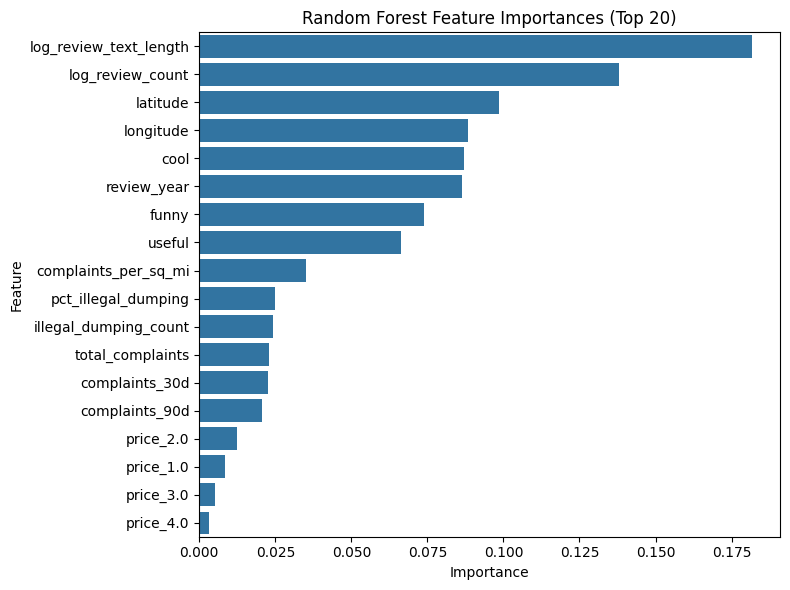

In [84]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=rf_importance_df,
    x="importance",
    y="feature",
)
plt.title("Random Forest Feature Importances (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Section 9.4.2 Interpretation of Feature Importances

The feature importance results show that the Random Forest relies most heavily on Yelp-derived attributes. `review_text_length` stands out as the top predictor, likely because its continuous range gives the model many useful split points. `review_count` follows closely, reflecting the stability that comes from businesses with more customer engagement.

Location and timing variables (`latitude`, `longitude`, and `review_year`) also rank highly. These features seem to capture neighborhood-level differences and broader temporal patterns in how ratings evolve.

User interaction metrics such as `cool`, `useful`, and `funny` contribute moderately. They do not dominate the model, but they offer additional signals about customer sentiment.

The cleanliness indicators fall in the middle of the ranking. Features like `complaints_per_sq_mi` and `pct_illegal_dumping` provide smaller but still meaningful contributions, which is consistent with the performance improvements observed when these variables were added.

Price categories appear near the bottom, suggesting they contain relatively limited predictive information.

Overall, the pattern reinforces that Yelp activity features drive most of the model’s predictive power, while cleanliness measures add complementary structure that helps explain variation not captured by Yelp data alone.


## Section 10 Model Comparison and Error Reduction

In this section we compare the performance of all three models:

- Model 1: Baseline Linear Regression (Yelp-only features)
- Model 2: XGBoost (Yelp + cleanliness features)
- Model 3: Random Forest (Yelp + cleanliness features)


In this section we summarize their performance on the held-out test set and examine how much error is reduced when moving from the baseline to the nonlinear ensemble models. We then interpret the differences in terms of model capacity, regularization, and the use of cleanliness indicators.

### Section 10.1 Consolidated Performance Metrics

In [85]:
comparison_df = pd.DataFrame({
    "Model": [
        "Baseline (Linear Regression)",
        "Random Forest (Yelp + Cleanliness)",
        "XGBoost (Yelp + Cleanliness)",
    ],
    "Test RMSE": [
        baseline_test_rmse,
        rf_test_rmse,
        xgb_test_rmse,
    ],
    "Test MAE": [
        baseline_test_mae,
        rf_test_mae,
        xgb_test_mae,
    ],
    "Test R²": [
        baseline_test_r2,
        rf_test_r2,
        xgb_test_r2,
    ],
})

comparison_df.style.format({
    "Test RMSE": "{:.4f}",
    "Test MAE": "{:.4f}",
    "Test R²": "{:.4f}",
})

,Model,Test RMSE,Test MAE,Test R²
0,Baseline (Linear Regression),1.2492,1.0096,0.0755
1,Random Forest (Yelp + Cleanliness),1.2168,0.9807,0.1229
2,XGBoost (Yelp + Cleanliness),1.2128,0.9777,0.1286


### Section 10.2 Test RMSE Across Models

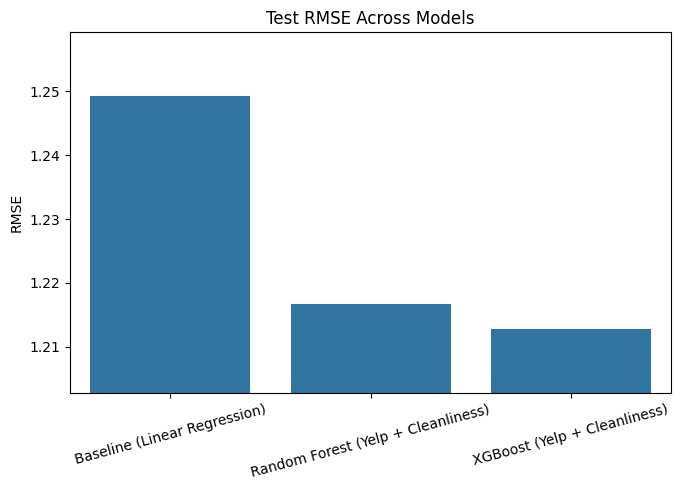

In [86]:
plt.figure(figsize=(7, 5))
sns.barplot(
    data=comparison_df,
    x="Model",
    y="Test RMSE",
)

plt.title("Test RMSE Across Models")
plt.ylabel("RMSE")
plt.xlabel("")

min_rmse = comparison_df["Test RMSE"].min()
max_rmse = comparison_df["Test RMSE"].max()
margin = 0.01

plt.ylim(min_rmse - margin, max_rmse + margin)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Section 10.3 Percentage RMSE Reduction vs Baseline

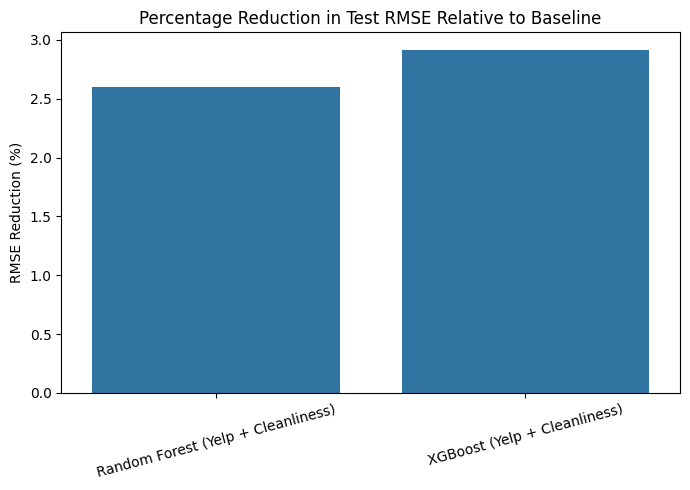

In [87]:
# Compute percentage improvement vs baseline for each model
baseline_rmse = comparison_df["Test RMSE"].iloc[0]

comparison_df["RMSE Reduction vs Baseline (%)"] = (
    (baseline_rmse - comparison_df["Test RMSE"]) / baseline_rmse * 100
)

plt.figure(figsize=(7, 5))
sns.barplot(
    data=comparison_df.iloc[1:],
    x="Model",
    y="RMSE Reduction vs Baseline (%)",
)

plt.title("Percentage Reduction in Test RMSE Relative to Baseline")
plt.ylabel("RMSE Reduction (%)")
plt.xlabel("")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Section 10.4 Interpretation of the Model Comparison

The comparison of the three models shows a clear progression in predictive performance.

The baseline linear regression, which relies only on Yelp-derived features, provides the weakest overall results. Its test RMSE and low R² indicate that although Yelp information carries some signal, the linear model is not flexible enough to capture the full variability in the ratings.

The Random Forest model improves on the baseline by a noticeable margin, reducing test RMSE to 1.2168 and roughly doubling the R² value. This improvement suggests that allowing nonlinear splits and interactions among features helps the model learn patterns that the linear regression cannot represent. At the same time, the Random Forest still exhibits a moderate gap between training and test performance, consistent with its tendency toward higher variance in large feature spaces.

XGBoost delivers the strongest performance, achieving the lowest test RMSE and the highest R² among the three models. Because it uses the same combined feature set as the Random Forest, the performance gain is likely due to the boosting framework and its built-in regularization. By fitting trees sequentially and adjusting for residual errors, XGBoost is able to extract more structure from the feature space while controlling overfitting more effectively than bagging alone.

Taken together, these results highlight several consistent themes. Cleanliness indicators contribute meaningful additional signal when combined with Yelp features, but the choice of modeling approach plays a larger role in overall performance. Nonlinear ensemble methods clearly outperform the linear baseline, and boosting provides the most favorable balance between model complexity and generalization for this prediction task.

## Section 11 Model Error Analysis
We compared model-level metrics in section 10, it is also important to understand how each model behaves on individual predictions. In this section, we examine residual patterns for the baseline linear model, the Random Forest, and XGBoost.

### Section 11.1 Compute Residuals for All Models

In [88]:
y_pred_baseline = baseline_lr.predict(X_test_yelp)
y_pred_rf       = best_rf.predict(X_test_full)
y_pred_xgb      = best_xgb.predict(X_test_full)

residuals_df = pd.DataFrame({
    "y_true": y_test,
    "baseline_resid": y_test - y_pred_baseline,
    "rf_resid":       y_test - y_pred_rf,
    "xgb_resid":      y_test - y_pred_xgb,
})

residuals_df.head()

,y_true,baseline_resid,rf_resid,xgb_resid
0,5.0,0.934152,1.009023,1.025450
1,5.0,1.281897,1.337186,1.340996
2,4.0,0.571811,1.241891,1.138662
3,4.0,0.120972,-0.018099,0.091490
4,4.0,-0.292672,-0.378761,-0.358471


### Section 11.2 Residual Distributions for 3 Models

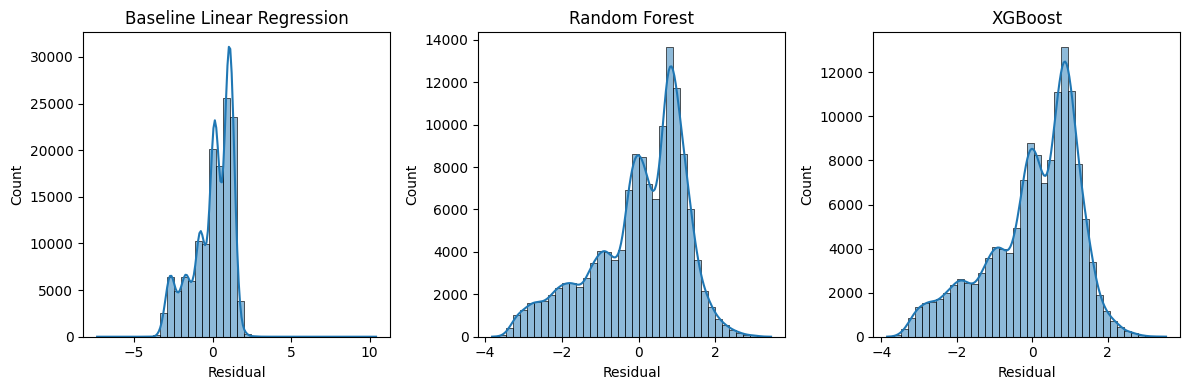

In [89]:
plt.figure(figsize=(12, 4))

for i, (resid_col, title) in enumerate([
    ("baseline_resid", "Baseline Linear Regression"),
    ("rf_resid", "Random Forest"),
    ("xgb_resid", "XGBoost"),
]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(residuals_df[resid_col], bins=40, kde=True)
    plt.title(title)
    plt.xlabel("Residual")

plt.tight_layout()
plt.show()

Interpretation of Residual Distributions:

The residual histograms reveal clear differences in how the three models behave on the test set.  

The baseline linear regression shows the widest and most irregular distribution, with long tails on both sides and several visible peaks. This pattern is consistent with the model’s limited flexibility: the linear specification cannot capture many of the nonlinear relationships present in the data, leading to frequent large errors in both directions.

The Random Forest residuals are more concentrated around zero, but the distribution still has noticeable spread and multiple smaller bumps. This reflects the model’s improved ability to capture nonlinear structure while still exhibiting some variance-related instability. The Random Forest reduces extreme errors compared with the baseline, yet the shape of the residuals suggests that the model may overfit certain regions of the feature space or react strongly to specific splits.

XGBoost produces the most compact and stable residual distribution. The histogram shows a clear central peak near zero with substantially fewer large deviations compared with the other two models. The residuals taper off more quickly on both sides, indicating that XGBoost makes fewer extreme mistakes and is better calibrated overall.

Therefore, the progression from baseline to Random Forest to XGBoost aligns well with the expected improvements from increasing model flexibility and introducing more effective regularization.


### Section 11.3 Residuals vs Predicted (XGBoost)

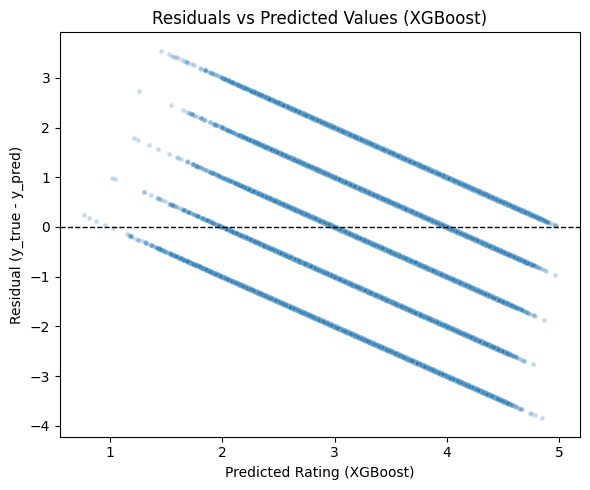

In [90]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=y_pred_xgb,
    y=residuals_df["xgb_resid"],
    alpha=0.25,
    s=12,
)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Predicted Rating (XGBoost)")
plt.ylabel("Residual (y_true - y_pred)")
plt.title("Residuals vs Predicted Values (XGBoost)")
plt.tight_layout()
plt.show()

Interpretation of Residuals vs Predicted:

The plot for XGBoost shows five clear diagonal bands. This happens because the true ratings take only five discrete values while the model produces continuous predictions. Each band corresponds to one star rating, so the pattern reflects the structure of the target rather than a modeling issue.

Within each band the residuals stay close to zero, which indicates that XGBoost makes relatively small errors across the full range of predicted ratings. The spread is also tighter than what we observed for the baseline and the Random Forest. This matches XGBoost's lower RMSE. It is also important that the bands do not tilt upward or downward, which means the model does not systematically overpredict or underpredict at particular rating levels.

There are a few points that fall farther from the center of the bands, but this is expected given the natural variability in Yelp reviews and the factors our features cannot capture. Overall, the plot suggests that XGBoost handles different rating levels in a stable and consistent way with no obvious signs of bias.



## Section 12: Cleanliness-Level Error Analysis and Conclusion

### Section 12.1 Error by Cleanliness Level (XGBoost)
Since XGBoost is the best-performing model among the three, the cleanliness-level error analysis in this section focuses on its predictions only. The goal of this section is to understand how the final model behaves across different neighborhood conditions rather than to re-compare all three models. The baseline linear model does not incorporate cleanliness features directly, and the Random Forest, while stronger than the baseline, does not match the overall stability and accuracy of XGBoost. For these reasons, it is most meaningful to examine the error patterns of the model we ultimately rely on.

In [91]:
test_df = X_test_full.copy().reset_index(drop=True)
test_df["y_true"] = y_test
test_df["xgb_pred"] = y_pred_xgb
test_df["abs_error"] = np.abs(test_df["y_true"] - test_df["xgb_pred"])

clean_feature = "complaints_per_sq_mi"

test_df["clean_bin"] = pd.qcut(
    test_df[clean_feature],
    q=4,
    labels=["Q1 (Cleanest)", "Q2", "Q3", "Q4 (Dirtiest)"]
)

clean_error = (
    test_df.groupby("clean_bin")["abs_error"]
    .mean()
    .reset_index()
    .rename(columns={"abs_error": "mean_abs_error"})
)

clean_error

/tmp/ipython-input-3683757212.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_df.groupby("clean_bin")["abs_error"]


,clean_bin,mean_abs_error
0,Q1 (Cleanest),1.070197
1,Q2,0.968999
2,Q3,0.915997
3,Q4 (Dirtiest),0.882495


### Section 12.2 Plot Error by Cleanliness Quantile

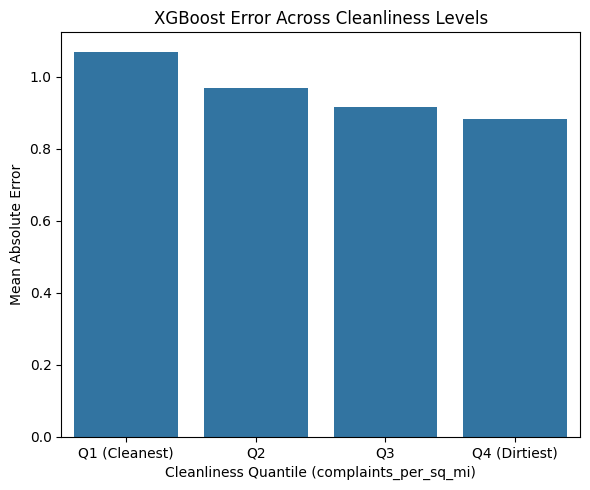

In [92]:
plt.figure(figsize=(6, 5))
sns.barplot(
    data=clean_error,
    x="clean_bin",
    y="mean_abs_error"
)
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cleanliness Quantile (complaints_per_sq_mi)")
plt.title("XGBoost Error Across Cleanliness Levels")
plt.tight_layout()
plt.show()

Interpretation of Cleanliness-Level Error Patterns：

The XGBoost errors show a clear pattern across cleanliness levels. The model makes the largest errors in the cleanest quartile (Q1), where the mean absolute error is about 1.07. In contrast, the errors steadily decrease as we move toward areas with more cleanliness complaints, with Q4 (the dirtiest quartile) having the lowest error.

This trend is consistent with how Yelp ratings behave in different neighborhoods. Businesses in cleaner areas often receive a wider range of ratings because factors such as food quality, service, or atmosphere carry more weight and vary considerably from place to place. These factors are harder for the model to infer from the available features, which makes predictions less accurate.

In dirtier areas, ratings tend to be more clustered and less influenced by subtle business-level differences. Because the complaint-based cleanliness indicators are part of the feature set, the model can use them to better align predictions with the underlying patterns in these neighborhoods. As a result, the error becomes slightly smaller and more stable as cleanliness decreases.

Overall, the differences across the four quartiles are not dramatic, suggesting that the model remains fairly consistent regardless of neighborhood conditions. However, the modest drop in error toward the dirtiest quartile indicates that cleanliness-related features do provide useful information for the final model.

## Section 13: Final Discussion

### 13.1 Final Conclusion

This project combined Yelp business information with neighborhood-level cleanliness indicators to study how well different models can predict review ratings.

The baseline linear model offered a simple point of comparison, while the Random Forest and XGBoost models showed clear improvements once additional environmental features were included.

XGBoost ultimately performed the best, producing more stable residual patterns and lower overall error. The cleanliness analysis also showed that rating predictions vary slightly across neighborhood conditions, suggesting that environmental factors do contribute useful signal.

Overall, the models behave consistently and the final approach provides a reasonable and interpretable way to forecast Yelp ratings at scale.


### 13.2 Model Limitations

Although XGBoost achieves the strongest performance among the three models, its accuracy is still limited by the information available in the dataset. Yelp ratings depend on many business-level factors such as food quality, customer service, waiting times, and internal management practices. These aspects are not represented directly in the features we use for prediction. Once the model accounts for the variables derived from Yelp activity and the cleanliness indicators, much of the remaining variation is likely explained by these unobserved characteristics. This helps clarify why prediction errors remain noticeable even in the cleanest neighborhoods, where small differences in business operations may influence ratings more than environmental conditions.

Another challenge arises from the inherent noise in the prediction task. A single business can receive a wide range of ratings from different customers, and no model can fully capture this variability. The environmental indicators included in the analysis are also aggregated at a relatively broad spatial and temporal scale, which limits how much detailed neighborhood information the model can use. Access to more precise environmental data or richer business-specific features could potentially lead to further improvements in accuracy.


### 13.3 Future Work

Future extensions of this project could focus on using the information we already have in a more expressive way.

One step would be to incorporate features drawn from the text of Yelp reviews. Representations that reflect the tone or themes of the reviews may capture aspects of the customer experience that simple counts or text length do not. It may also be useful to add geographic or temporal details that vary over time, since neighborhoods can change in ways that influence both customer behavior and local conditions.

There are also modeling directions worth exploring. Methods that treat ratings as ordered categories rather than numerical values could better reflect the structure of the response. Models that provide calibrated uncertainty estimates might help distinguish confident predictions from cases where the available information is limited.

Finally, applying the approach to data from other cities or to different time periods would help assess how general these results are and whether the patterns we observed remain consistent in other settings.


### 13.4 Practical Implications

The findings have relevance for both city agencies and the businesses represented in the data. The relationship between neighborhood cleanliness and rating patterns suggests that local environmental conditions play a small but consistent role in how customers evaluate their experiences. City agencies that track neighborhood complaints or maintain public spaces may find value in these results, since changes in the surrounding environment could have indirect effects on how businesses are perceived. This does not imply that cleanliness determines ratings on its own, but it does show that the broader setting is part of the picture.

For business owners, the results highlight that customer evaluations are shaped mostly by the experience inside the business, but external conditions still contribute in a noticeable way. Understanding this mix of influences may help set expectations about how much control a business has over its rating outcomes. The analysis also suggests that rating patterns may vary systematically across different neighborhoods, and platforms such as Yelp could use this information to refine how they contextualize or present ratings to users. Taking both customer factors and environmental conditions into account can lead to a more balanced view of business performance.
